# 0. Problem description
--------------------------
I've got this dataset of financial time series from my freinds at TenViz who's job is the magic of predicting stock market movements. The problem was formulated as follows:
> ... to predict *target_class* based on values of *target_variable* & available features (dataset 'test_task_data.csv'). Before building a classifier, please pay attention to the nature of features and specific aspects of working with time series. Also, you can use *target_values* to derive useful information and additional features. As a train set use dataset from 2012-01-01 till 2016-12-31, as a test set used from 2017-01-02 till 2018-06-19. Finally, evaluate your model & provide analysis with short comments.
> The results of the work should contain:
> * Description of the steps of the solution of the task.
> * Runnable implementation code in Python.
> * PDF with the charts

In this kernel/ notebook I review the raw time series data, apply necessery transformations and scaling, formulate a machine learning problem and build a classifier based on a stacked LSTM RNN.

## Contents:
1. [Load and Review Data](#1)
2. [Feature Engineering](#2)
3. [Data Pre-processing for LSTM Model](#3)
4. [LSTM Model - Batch Training and Predictiction](#4)
5. [APPENDIX - EDA for Individual Time Series](#5)

In [24]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap

%matplotlib inline

# <a name="1"></a> 1. Load and Review Data
------------------

In [25]:
# Import data, convert string dates to 'datetime64' and set the date column as index:
df = pd.read_csv('../input/test_task_data.csv',
                 parse_dates=['date'],
                 infer_datetime_format=True,
                 index_col='date',
                 thousands=',',
                 decimal='.'
                )

In [26]:
#  Review the general info on data, paying attention to missing values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1687 entries, 2012-01-02 to 2018-06-19
Data columns (total 19 columns):
feature_1       1687 non-null float64
feature_2       1687 non-null float64
feature_3       1687 non-null float64
feature_4       1687 non-null float64
feature_5       1479 non-null float64
feature_6       1687 non-null float64
feature_7       1687 non-null float64
feature_8       1687 non-null float64
feature_9       1687 non-null float64
feature_10      1687 non-null float64
feature_11      1687 non-null float64
feature_12      1687 non-null float64
feature_13      1687 non-null float64
feature_14      1687 non-null float64
feature_15      1687 non-null float64
feature_16      1687 non-null float64
Unnamed: 17     0 non-null float64
target_value    1687 non-null float64
target_class    1687 non-null int64
dtypes: float64(18), int64(1)
memory usage: 263.6 KB


In [27]:
# Let's remove the empty column and look at some examples of data:
df = df.drop(columns='Unnamed: 17')
print(f'data shape = {df.shape}')
df.head()

data shape = (1687, 18)


feature_1  feature_2      ...       target_value  target_class
date                                  ...                                 
2012-01-02    1997.00     107.38      ...          59.324325             0
2012-01-03    2054.50     112.13      ...          60.971989             0
2012-01-04    2041.25     113.70      ...          61.100708             0
2012-01-05    2013.00     112.74      ...          60.808938             0
2012-01-06    2045.75     113.06      ...          60.448514             0

[5 rows x 18 columns]

In [28]:
# It appears that 'feature_5' has missing values up to 2012-10-18
# let's fill them backwards
df.feature_5 = df.feature_5.fillna(method='bfill')

In [29]:
# Basic statistics of the data:
df.describe()

feature_1    feature_2      ...       target_value  target_class
count  1687.000000  1687.000000      ...        1687.000000   1687.000000
mean   1874.441766    78.308648      ...          68.492905      0.483106
std     208.258411    28.412734      ...           7.947151      0.499863
min    1432.500000    27.880000      ...          48.508190      0.000000
25%    1738.625000    51.705000      ...          63.116075      0.000000
50%    1877.000000    68.580000      ...          67.500964      0.000000
75%    2030.875000   108.395000      ...          73.274163      1.000000
max    2539.500000   126.220000      ...          91.048496      1.000000

[8 rows x 18 columns]

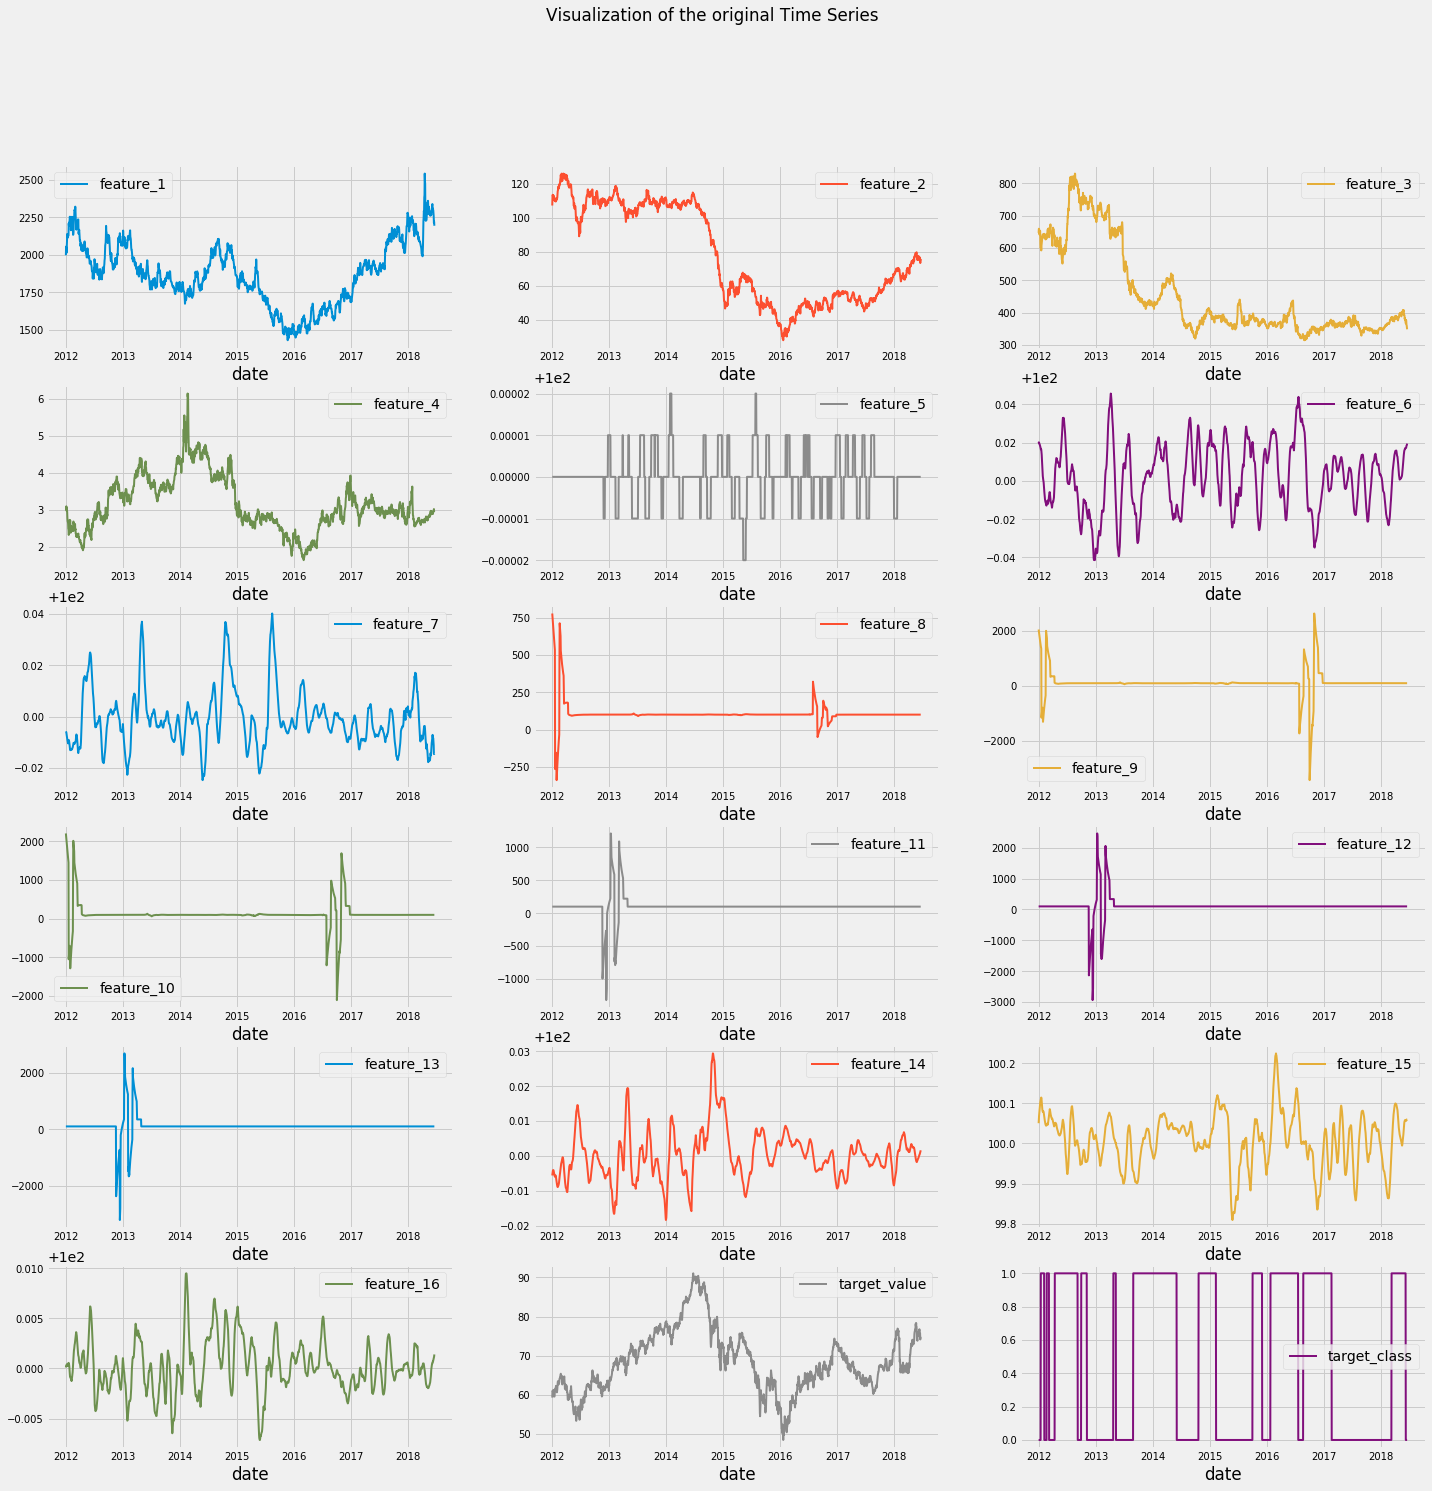

In [30]:
# Plot the time series
plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

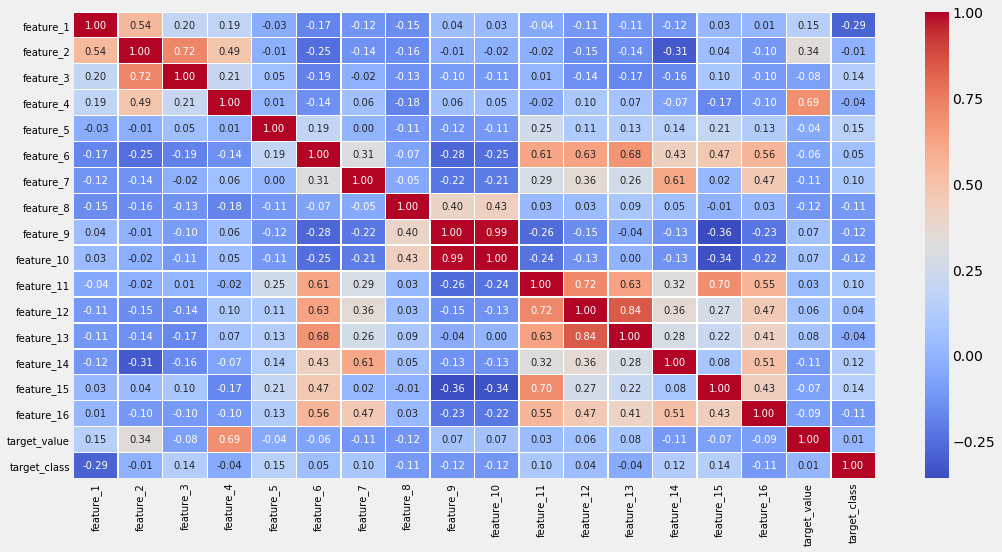

In [31]:
# Let's also draw a heatmap visualization of the correlation matrix
corr_matrix = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# <a name="2"></a> 2. Feature Engineering
-------
### What do we have from the raw data review?
* Exploratory Data Analysis of individual time series is visualized in the [APPENDIX](#index) below.
* The raw data contain stochastic time series, including 'target_value'. Predicting/ making classification based on stochastic variable values may force the model to learn the 'persistence' mode (i.e. yhat(t+1) = y(t)), resulting in little predictive power. Defining the model to predict (make classification from) the difference in values between the time steps rather than value itself, is a stronger test of its predictive power. 
* The raw data are weakly correleted with the target_value and the target_class and among each other with rare exceptions. The predictive power could be in temporal effects. 
* The raw data are at different scales, therefore one more review after data transformation is needed to check if a standartization (for ~normal distribution of values) / normalization (for other distributions) is required to ensure efficient learning of NN models.

Possible nature | TS_name | Description | Transformation | Rescaling after transformation
:---: | :-- | :-- | :-- | :--
class | target_class | binary (48%-1s, 52%-0s) | None | None
stock index or indicator like RSI | [target_value](#target_value) | unimodal, bell-shaped, skewed to the right, stochastic trend with values in [48, 91], order +2 autocorr | pc_change or log diff | Standard
stock index | [feature_1](#feature_1) | unimodal, bell-shaped, slightly skewed to the right, stochastic trend with values in [1432, 2539], order +2 autocorr | pc_change or log diff | Standard
stock index | [feature_2](#feature_2) | bimodal, stochastic trend with values in [27, 126 ], order +2 autocorr | pc_change or log diff | Standard or MinMax
stock index | [feature_3](#feature_3) | unimodal, strongly skewed to the right,  stochastic trend with values in [315, 830], order +2 autocorr  | pc_change or log diff | Standard or MinMax
stock index | [feature_4](#feature_4) | unimodal, skewed to the right,  stochastic trend with values in [1, 6 ], order +2 autocorr | pc_change or log diff | Standard
technical indicator | [feature_5](#feature_5) | unimodal, 5 descrete values  in [100+-0.00002], ordr +2 autocorr |  pc_change or log diff | Standard
technical indicator | [feature_6](#feature_6) | unimodal, bell-shaped, ranging in [100+- 0.04], order +2 autocorr | pc_change or log diff | Standard
technical indicator | [feature_7](#feature_7) | unimodal, skewed to the right, ranging in [100+-0.04], order -29/+31 autocorr  | pc_change or log diff | Standard
technical indicator | [feature_8](#feature_8) | ranging around 100, occasional spikes in range [-340, +780] - [Q1'12, Q4'16], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_9](#feature_9) | ranging around 100, occasional spikes in range [-3413, +2626] - [Q1'12, Q4'16], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_10](#feature_10) | ranging around 100, occasional spikes in range [-2104, +2206] - [Q1'12, Q4'16], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_11](#feature_11) | ranging around 100, occasional spikes in range [-1321, +1213 ] - [Q4'12-Q1'13], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_12](#feature_12) | ranging around 100, occasional spikes in range [-2933, +2462 ] - [Q4'12-Q1'13], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_13](#feature_13) | ranging around 100, occasional spikes in range [-3206, +2687 ] - [Q4'12-Q1'13], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator (oscillator) | [feature_14](#feature_14) | unimodal, skewed to the right, ranging in  [100+-0.02], autocorr +32 | pc_change or log diff | Standard
technical indicator (oscillator) | [feature_15](#feature_15) | unimodal, bell-shaped, skewed to the left, ranging in [100+-0.02], autocorr -38 | pc_change or log diff | Standard
technical indicator (oscillator) | [feature_16](#feature_16) | unimodal, bell-shaped, ranging in [100+-0.01], autocorr +14 | pc_change or log diff | Standard

### Let's try a simple approach first and apply the pc_change to all *features* and *target_value* time series.

In [32]:
# We want to keep original time series for the EDA in APPENDIX
# So we apply the 'pc_change()' transformation to a copy of the original time series
df_transform = df.loc[:,:'target_value'].copy().pct_change(1)
df_transform.head()

feature_1  feature_2      ...         feature_16  target_value
date                                  ...                                 
2012-01-02        NaN        NaN      ...                NaN           NaN
2012-01-03   0.028793   0.044235      ...       1.599998e-06      0.027774
2012-01-04  -0.006449   0.014002      ...       4.999987e-07      0.002111
2012-01-05  -0.013840  -0.008443      ...       2.999991e-07     -0.004775
2012-01-06   0.016269   0.002838      ...       4.999983e-07     -0.005927

[5 rows x 17 columns]

In [33]:
# fill the 1st row with NA data
df_transform.fillna(method='bfill', inplace=True)
df_transform.head()

feature_1  feature_2      ...         feature_16  target_value
date                                  ...                                 
2012-01-02   0.028793   0.044235      ...       1.599998e-06      0.027774
2012-01-03   0.028793   0.044235      ...       1.599998e-06      0.027774
2012-01-04  -0.006449   0.014002      ...       4.999987e-07      0.002111
2012-01-05  -0.013840  -0.008443      ...       2.999991e-07     -0.004775
2012-01-06   0.016269   0.002838      ...       4.999983e-07     -0.005927

[5 rows x 17 columns]

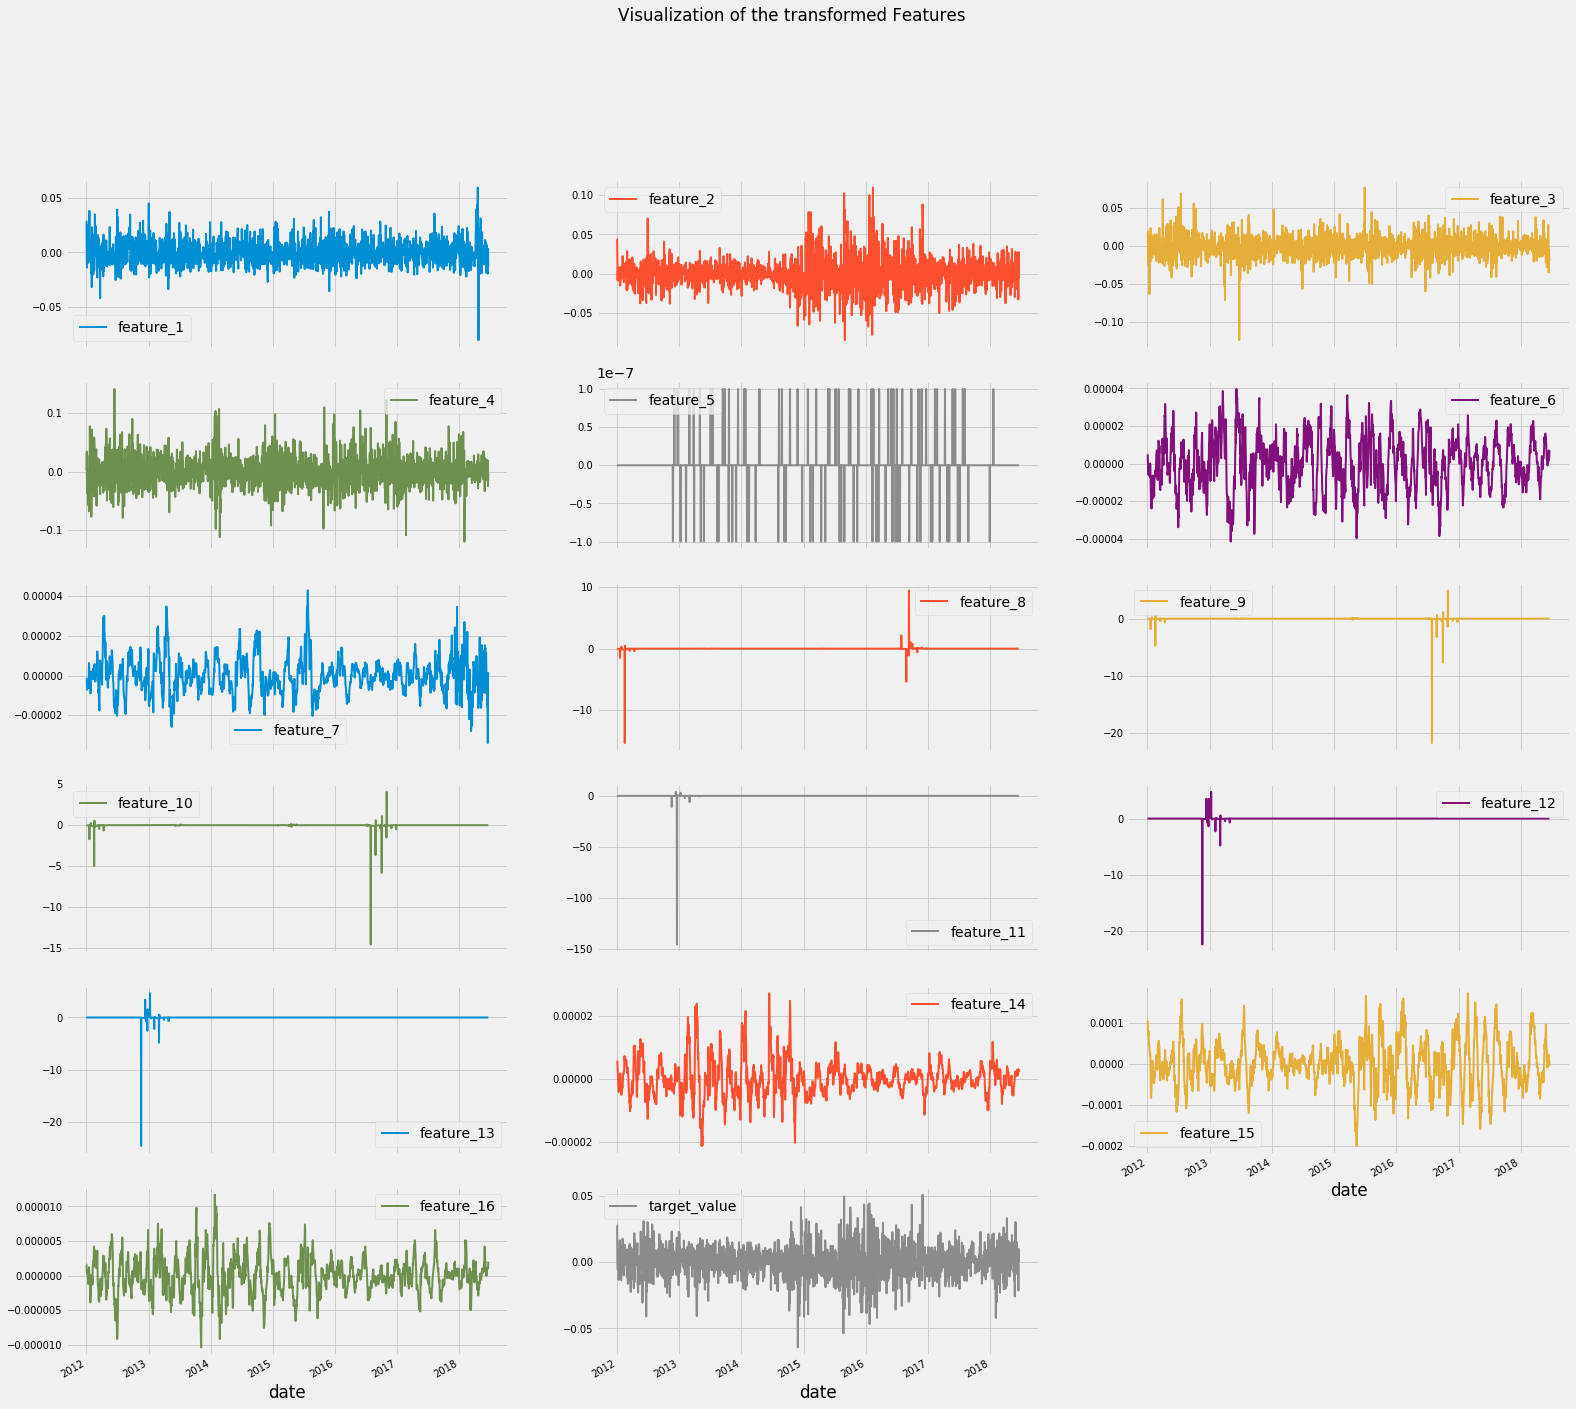

In [34]:
# Plot the transformed time series
plt.style.use('fivethirtyeight')
df_transform.plot(subplots=True,
                  layout=(6, 3),
                  figsize=(24,24),
                  fontsize=10, 
                  linewidth=2, 
                  title='Visualization of the transformed Features')
plt.show()

### (!) We see that the mean and variance look almost constant except for a few outliers, but it is better to rescale the transformed time series either with StandardScaler or MinMaxScaler(-1, 1) for efficient model learning. The scalers are fit on the traning data and then applied to the test data.

In [35]:
# Split train and test data
train_features = df_transform.loc['2012-01-02':'2016-12-31']
train_labels = df.loc['2012-01-02':'2016-12-31', 'target_class']

test_features = df_transform.loc['2017-01-02':'2018-06-19']
test_labels = df.loc['2017-01-02':'2018-06-19', 'target_class']

# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window
T = 45  # my choice of the timesteps window

prepend_features = train_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features, test_features], axis=0)

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((1305, 17), (1305,), (426, 17), (382,))

In [36]:
# Rescale the features
from sklearn.preprocessing import StandardScaler  # MinMaxScaler

scaler = StandardScaler()  # MinMaxScaler(feature_range=(-1,1))
scaled_train_features = pd.DataFrame(scaler.fit_transform(train_features.values),
                                     index=train_features.index,
                                     columns=train_features.columns)
# The Scaler is fit on the training set and then applied to the test set
scaled_test_features = pd.DataFrame(scaler.transform(test_features.values),
                                    index=test_features.index,
                                    columns=test_features.columns)

scaled_train_features.shape, scaled_test_features.shape

((1305, 17), (426, 17))

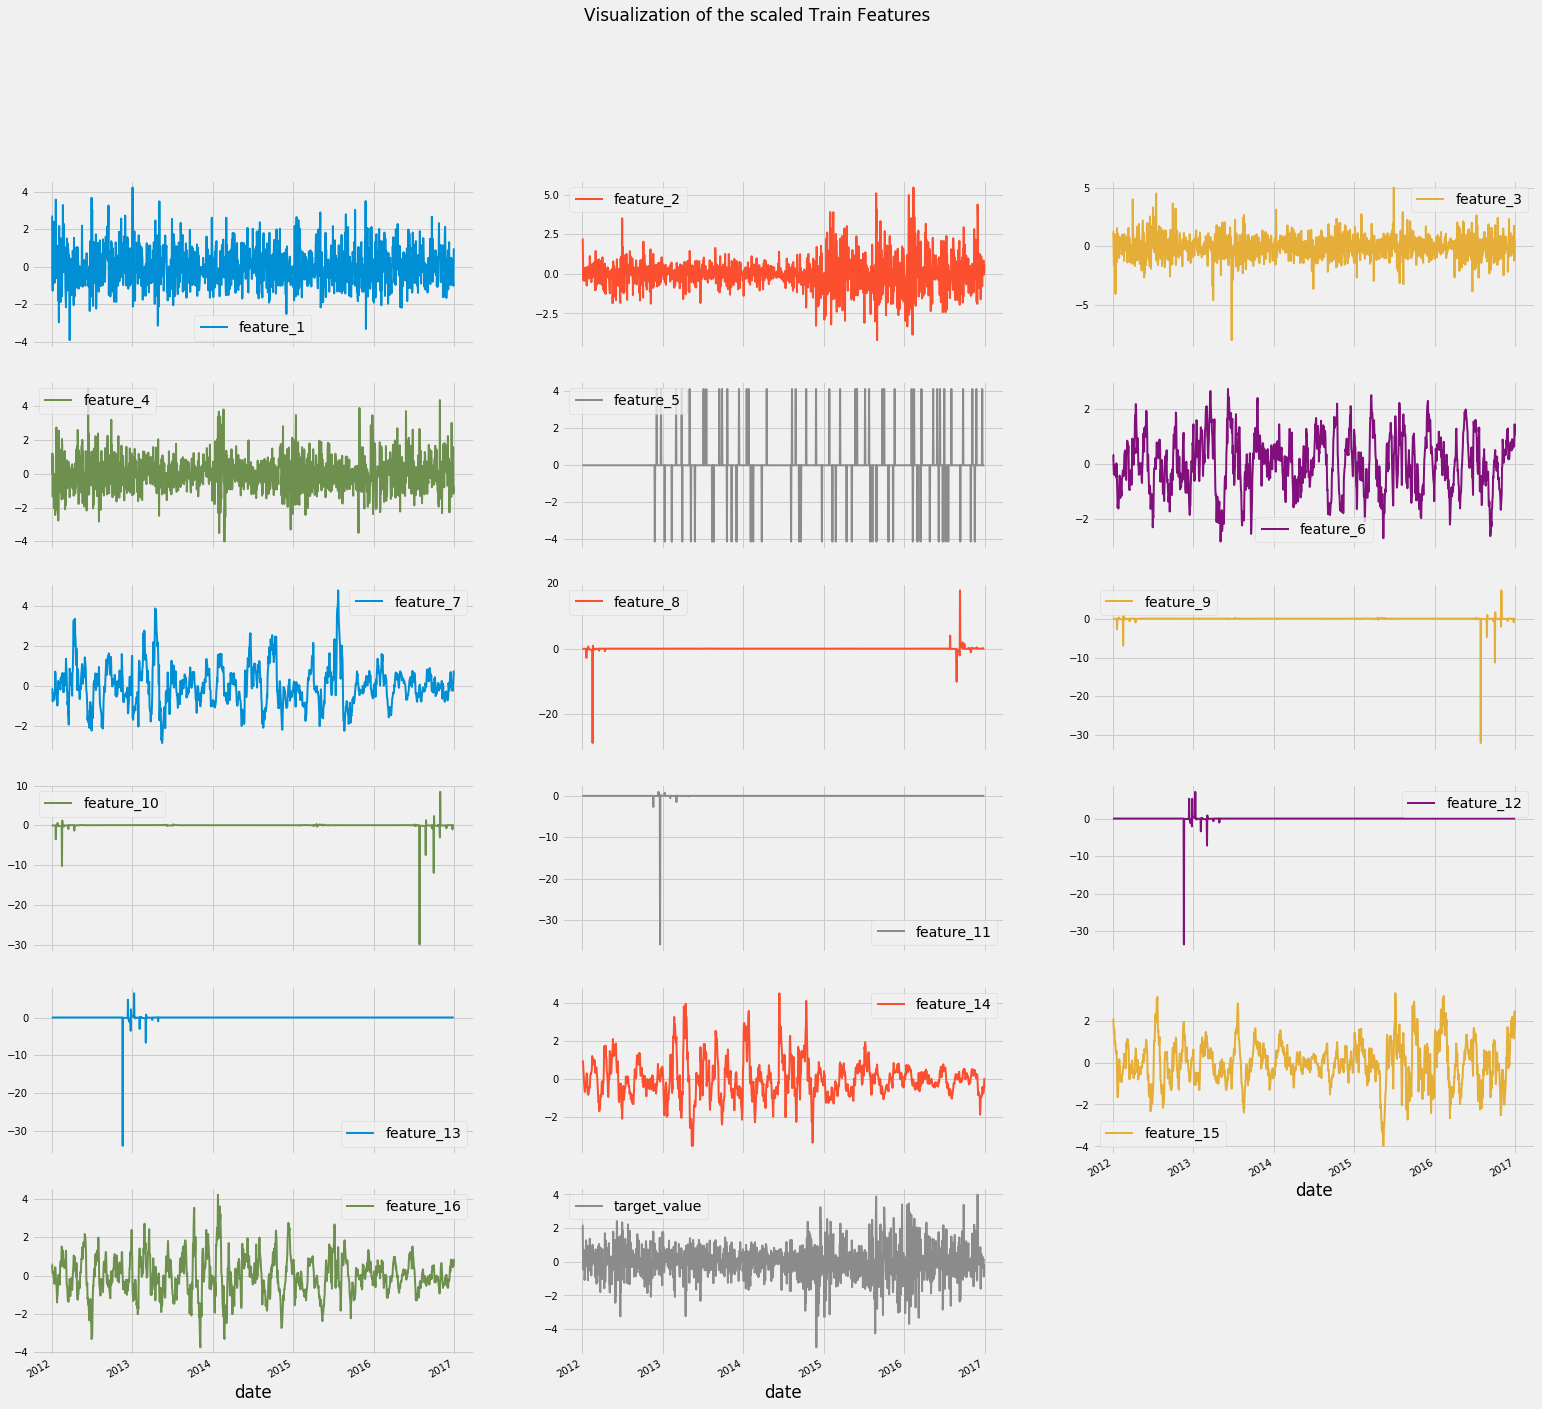

In [37]:
# Plot the rescaled_train_features
plt.style.use('fivethirtyeight')
scaled_train_features.plot(subplots=True,
                           layout=(6, 3),
                           figsize=(24,24),
                           fontsize=10, 
                           linewidth=2, 
                           title='Visualization of the scaled Train Features')
plt.show()

>  ## An alternative simplified transformation of the time-series (just to keep in mind): 
> Normalize sequences X = X/X_0 - 1, where X_0 is 1st example in the series:
> * X_0_train, X_0_test = X_train[ : , 0], X_test[ : , 0]
> * X_train = X_train/X_0_train[ : , None, :] - 1
> * X_test = X_test/X_0_test[ : , None, :] - 1

# <a name="3"></a> 3. Data Pre-processing for LSTM Model
------------------------------------
Input data for the Keras LSTM layer has 3 dimensions: (M, T, N), where 
* M - number of examples (2D: sequences of timesteps x features), 
* T - sequence length (timesteps) and 
* N - number of features (input_dim)

In [38]:
# Create sequences of T timesteps
X_train, y_train = [], []
for i in range(train_labels.shape[0] - (T-1)):
    X_train.append(scaled_train_features.iloc[i:i+T].values)
    y_train.append(train_labels.iloc[i + (T-1)])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(test_labels.shape[0]):
    X_test.append(scaled_test_features.iloc[i:i+T].values)
    y_test.append(test_labels.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)  

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (1261, 45, 17), (1261, 1)
Test data dimensions: (382, 45, 17), (382, 1)


# <a name="4"></a> 4. LSTM Model - Batch Training and Predictiction
-------------------------

In [39]:
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

layers=[8, 8, 8, 1], train_examples=1261, test_examples=382
batch = 1261, timesteps = 45, features = 17, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 45, 8)             832       
_________________________________________________________________
batch_normalization_22 (Batc (None, 45, 8)             32        
_________________________________________________________________
lstm_23 (LSTM)               (None, 45, 8)             544       
_________________________________________________________________
batch_normalization_23 (Batc (None, 45, 8)             32        
_________________________________________________________________
lstm_24 (LSTM)               (None, 8)                 544       
_________________________________________________________________
batch_normalization_24 (Batc 

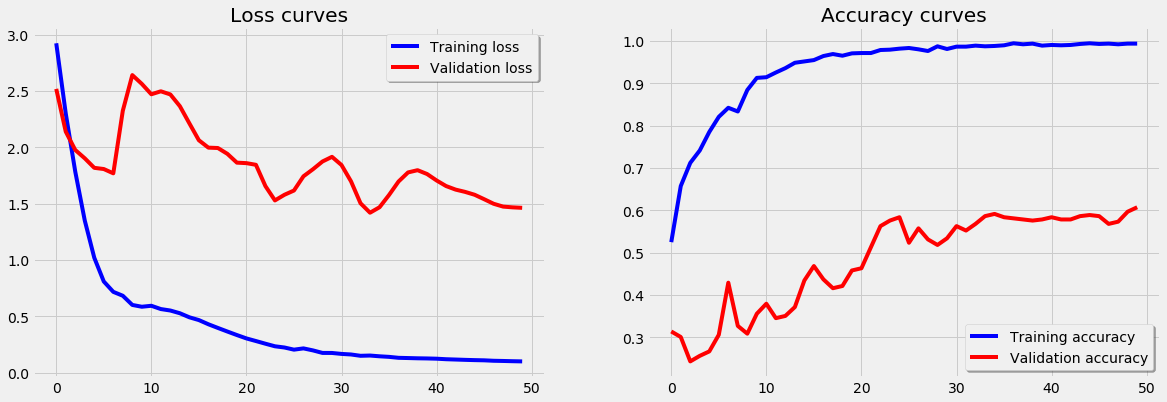

In [60]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 50                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_test[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,verbose=0,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['acc'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_acc'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [41]:
y_hat = model.predict_classes(X_test, batch_size=M_TEST, verbose=1)
#score = sum(y_hat == y_test) / len(y_test)
#print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
for i in range(y_hat.shape[0]):
    print(index[i], y_hat[i], y_test[i])

382/382 [==============================] - 2s 5ms/step
2017-01-02 00:00:00 [1] [1]
2017-01-03 00:00:00 [1] [1]
2017-01-04 00:00:00 [1] [1]
2017-01-05 00:00:00 [1] [1]
2017-01-06 00:00:00 [1] [1]
2017-01-09 00:00:00 [1] [1]
2017-01-10 00:00:00 [1] [1]
2017-01-11 00:00:00 [1] [1]
2017-01-12 00:00:00 [1] [1]
2017-01-13 00:00:00 [1] [1]
2017-01-16 00:00:00 [1] [1]
2017-01-17 00:00:00 [1] [1]
2017-01-18 00:00:00 [1] [1]
2017-01-19 00:00:00 [1] [1]
2017-01-20 00:00:00 [1] [1]
2017-01-23 00:00:00 [1] [1]
2017-01-24 00:00:00 [1] [1]
2017-01-25 00:00:00 [1] [1]
2017-01-26 00:00:00 [1] [1]
2017-01-27 00:00:00 [1] [1]
2017-01-30 00:00:00 [1] [1]
2017-01-31 00:00:00 [1] [1]
2017-02-01 00:00:00 [1] [1]
2017-02-02 00:00:00 [1] [1]
2017-02-03 00:00:00 [0] [1]
2017-02-06 00:00:00 [0] [1]
2017-02-07 00:00:00 [0] [1]
2017-02-08 00:00:00 [0] [1]
2017-02-09 00:00:00 [0] [1]
2017-02-10 00:00:00 [0] [1]
2017-02-13 00:00:00 [0] [1]
2017-02-14 00:00:00 [0] [1]
2017-02-15 00:00:00 [0] [1]
2017-02-16 00:00:00 [

2018-04-13 00:00:00 [1] [1]
2018-04-16 00:00:00 [1] [1]
2018-04-17 00:00:00 [1] [1]
2018-04-18 00:00:00 [1] [1]
2018-04-19 00:00:00 [1] [1]
2018-04-20 00:00:00 [1] [1]
2018-04-23 00:00:00 [1] [1]
2018-04-24 00:00:00 [1] [1]
2018-04-25 00:00:00 [1] [1]
2018-04-26 00:00:00 [1] [1]
2018-04-27 00:00:00 [1] [1]
2018-04-30 00:00:00 [1] [1]
2018-05-01 00:00:00 [1] [1]
2018-05-02 00:00:00 [1] [1]
2018-05-03 00:00:00 [1] [1]
2018-05-04 00:00:00 [1] [1]
2018-05-07 00:00:00 [1] [1]
2018-05-08 00:00:00 [1] [1]
2018-05-09 00:00:00 [1] [1]
2018-05-10 00:00:00 [1] [1]
2018-05-11 00:00:00 [1] [1]
2018-05-14 00:00:00 [1] [1]
2018-05-15 00:00:00 [1] [1]
2018-05-16 00:00:00 [1] [1]
2018-05-17 00:00:00 [1] [1]
2018-05-18 00:00:00 [1] [1]
2018-05-21 00:00:00 [1] [1]
2018-05-22 00:00:00 [1] [1]
2018-05-23 00:00:00 [1] [1]
2018-05-24 00:00:00 [1] [1]
2018-05-25 00:00:00 [1] [1]
2018-05-28 00:00:00 [1] [1]
2018-05-29 00:00:00 [1] [1]
2018-05-30 00:00:00 [1] [1]
2018-05-31 00:00:00 [1] [1]
2018-06-01 00:00:00 

# <a name="5"></a> 5. APPENDIX - Exploratory Data Analysis for Individual Time Series
### <a name="index"></a> INDEX:

Reference | Reference | Reference
:-- | :-- | :--
[EDA Function](#eda_function) | [A-5. feature_5](#feature_5) | [A-11. feature_11](#feature_11) 
[A-0. target_value](#target_value) | [A-6. feature_6](#feature_6)  | [A-12. feature_12](#feature_12) 
[A-1. feature_1](#feature_1) | [A-7. feature_7](#feature_7) | [A-13. feature_13](#feature_13) 
[A-2. feature_2](#feature_2) | [A-8. feature_8](#feature_8) | [A-14. feature_14](#feature_14) 
[A-3. feature_3](#feature_3) | [A-9. feature_9](#feature_9) | [A-15. feature_15](#feature_15) 
[A-4. feature_4](#feature_4) | [A-10. feature_10](#feature_10) | [A-16. feature_16](#feature_16) 

<h1 id="eda_function"> EDA Function </h1>

In [42]:
# Let's define a EDA function for repeated calls on individual time series:

import statsmodels.api as sm  # seasonal trend decomposition
from statsmodels.graphics import tsaplots   # autocorrelation

def eda(df_name, ts_name, decomp_model='additive'):
    """ 
    Inputs: df_name - name of the dataframe
            ts_name - name of the time series in the dataframe
            decomp_model - 'additive'/'multiplicative'
    Outputs: EDA statistics and plots for individual time series in df_name
    """
    # Statistics
    print(f'Statistic of {ts_name} time series')
    print(df_name[ts_name].describe())
    
    # Plotting
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(24,24))
    fig.suptitle(f'Visualization of the "{ts_name}" time series', fontsize=24)
        
    # Observed values of the time series against target_class values
    df_name[ts_name].plot(ylim=[df_name[ts_name].min(), df_name[ts_name].max()],
                          linewidth=2, ax=axs[0,0])
    axs[0,0].set_title('Observed values (red/green where target_class=0/1)')
    axs[0,0].set_xlabel('')
    axs[0,0].fill_between(df_name.index, df_name[ts_name], 
                          where=(df_name.target_class==0),
                          facecolor='red', alpha=0.5)
    axs[0,0].fill_between(df_name.index, df_name[ts_name], 
                          where=(df_name.target_class==1),
                          facecolor='green', alpha=0.5)
    axs[0,0].axvline('2017-01-01', color='red', linestyle='dashed')
    
    # Seasonality, trend and noise in time series data
    decomp = sm.tsa.seasonal_decompose(df_name[ts_name],
                                       model=decomp_model)
    decomp.trend.plot(linewidth=2, ax=axs[0,1])
    axs[0,1].set_title('Trend values')
    axs[0,1].set_xlabel('')
    decomp.seasonal.plot(linewidth=2, ax=axs[1,0])
    axs[1,0].set_title('Seasonal values')
    axs[1,0].set_xlabel('')
    decomp.resid.plot(linewidth=2, ax=axs[1,1])
    axs[1,1].set_title('Residual values')
    axs[1,1].set_xlabel('')
    
    # Distribution of values of time series
    df_name[ts_name].plot.hist(bins=30, ax=axs[2,0])
    axs[2, 0].set_title('Histogram')
    df_name[[ts_name]].boxplot(ax=axs[2,1])
    axs[2, 1].set_title('Boxplot')
        
    # Autocorrelation of time series
    tsaplots.plot_acf(df_name[ts_name], lags=40, ax=axs[3,0])
    tsaplots.plot_pacf(df_name[ts_name], lags=40, ax=axs[3,1])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# <a name="target_value"></a> A-0. target_value 
[Back to INDEX](#index)

Statistic of target_value time series
count    1687.000000
mean       68.492905
std         7.947151
min        48.508190
25%        63.116075
50%        67.500964
75%        73.274163
max        91.048496
Name: target_value, dtype: float64


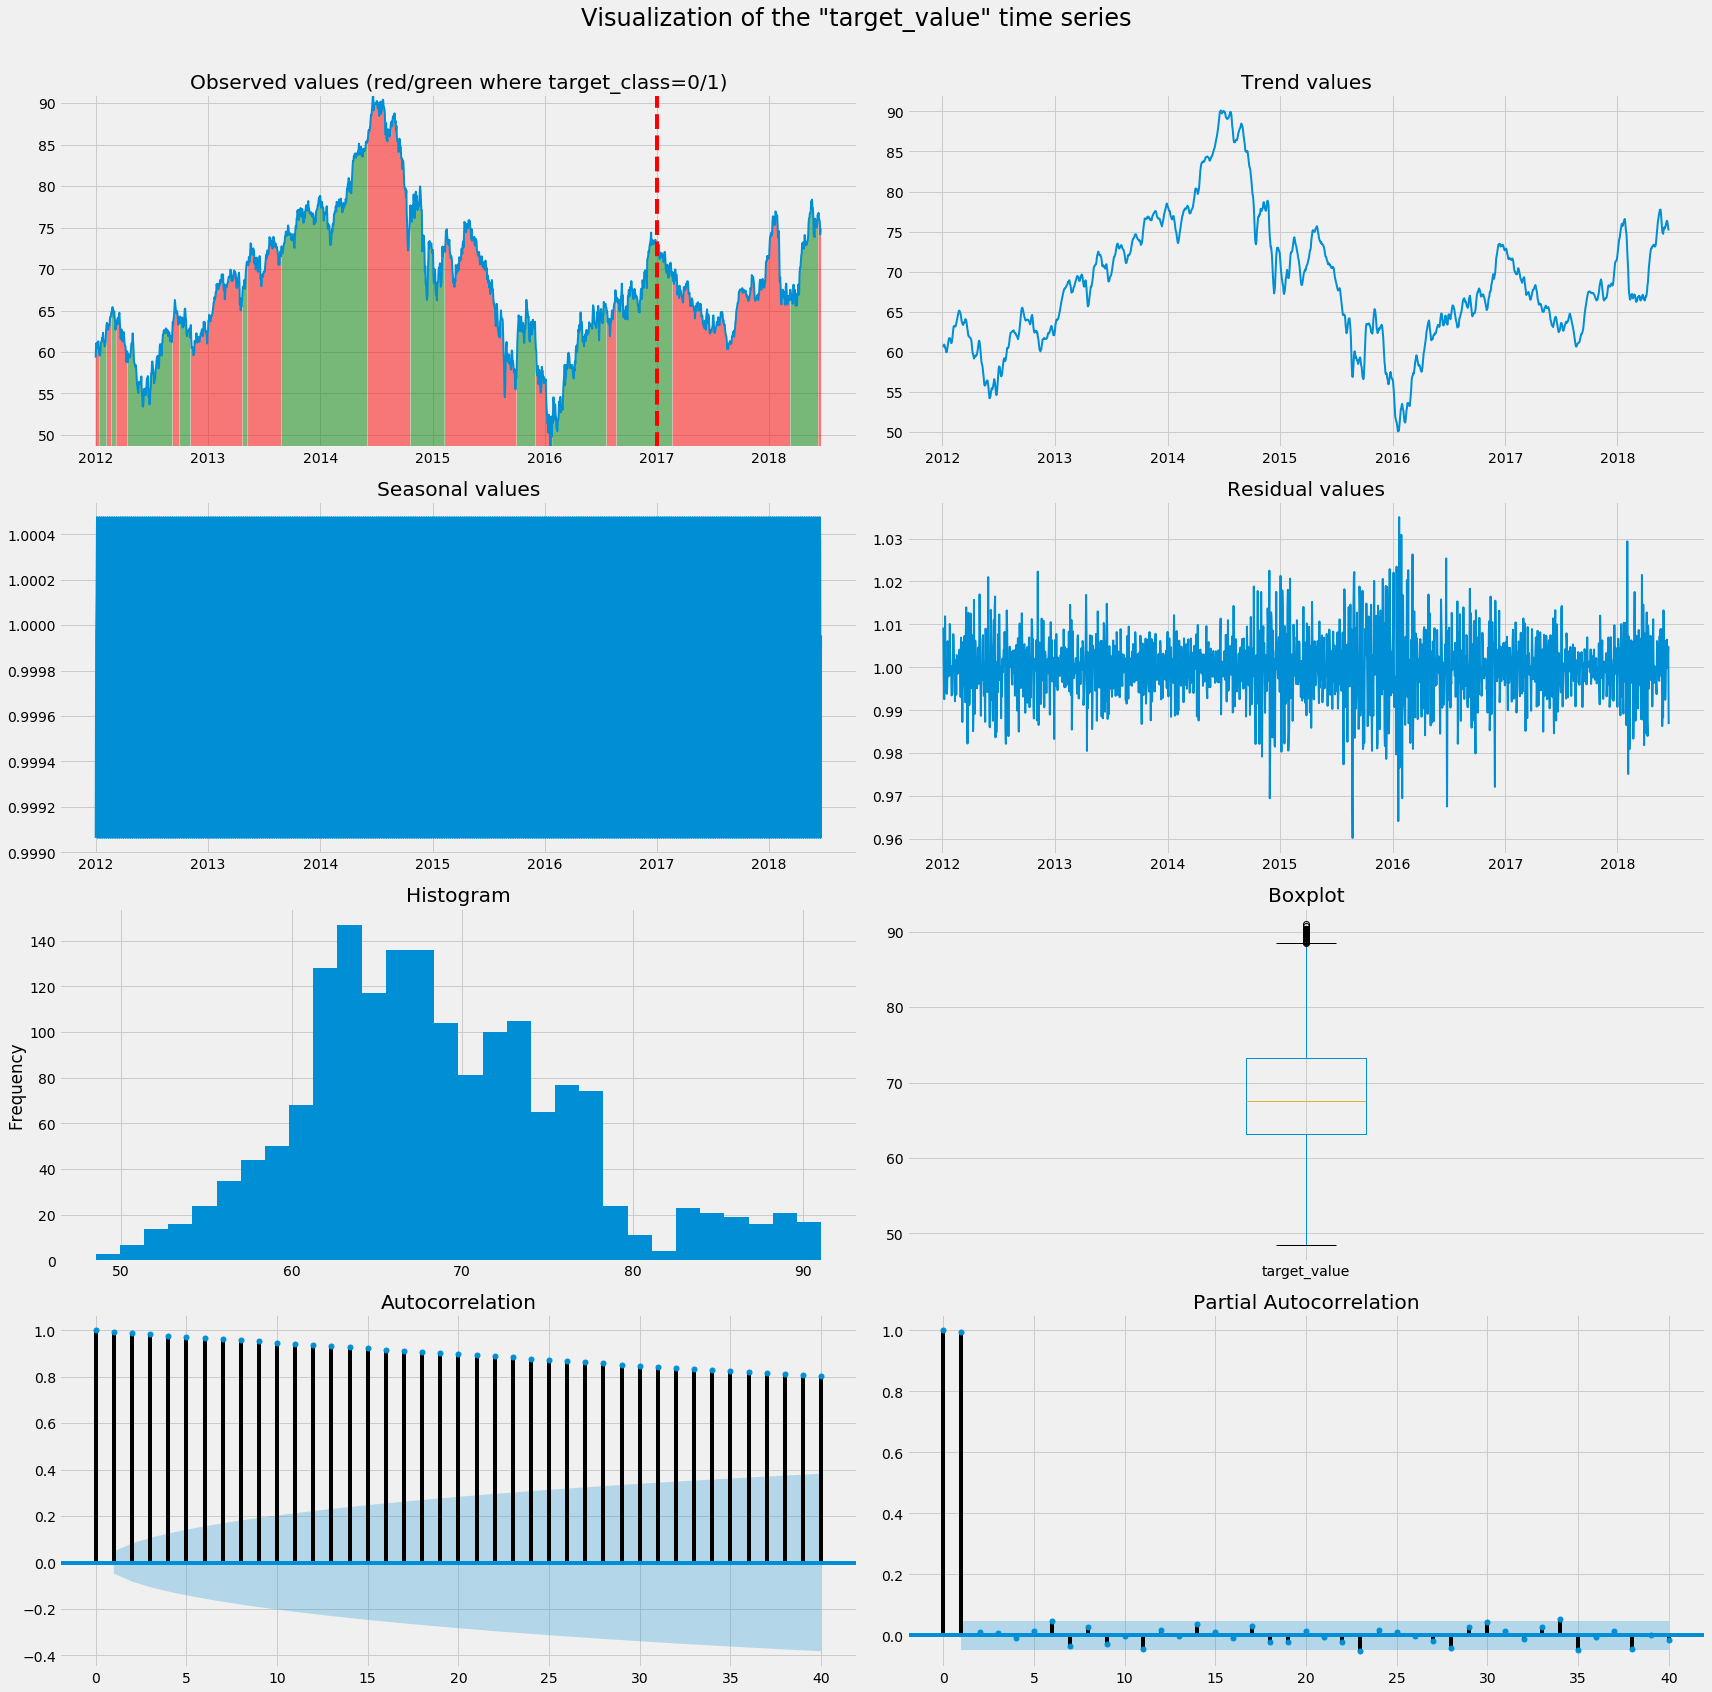

In [43]:
# Call EDA function to explore the time series
eda(df, 'target_value', 'multiplicative')


### Conclusion: 
* **target_value** is unimodal bell-shaped (slightly skewed to the right); 
* decomposed into trend and stochastic noise;
* percentage change is likely to have stationarity property
* alternative - log transformation of the variable
* it is possible to apply z-score standartization (sklearn StandardScaler)

# <a name="feature_1"></a> A-1. feature_1
[Back to INDEX](#index)

Statistic of feature_1 time series
count    1687.000000
mean     1874.441766
std       208.258411
min      1432.500000
25%      1738.625000
50%      1877.000000
75%      2030.875000
max      2539.500000
Name: feature_1, dtype: float64


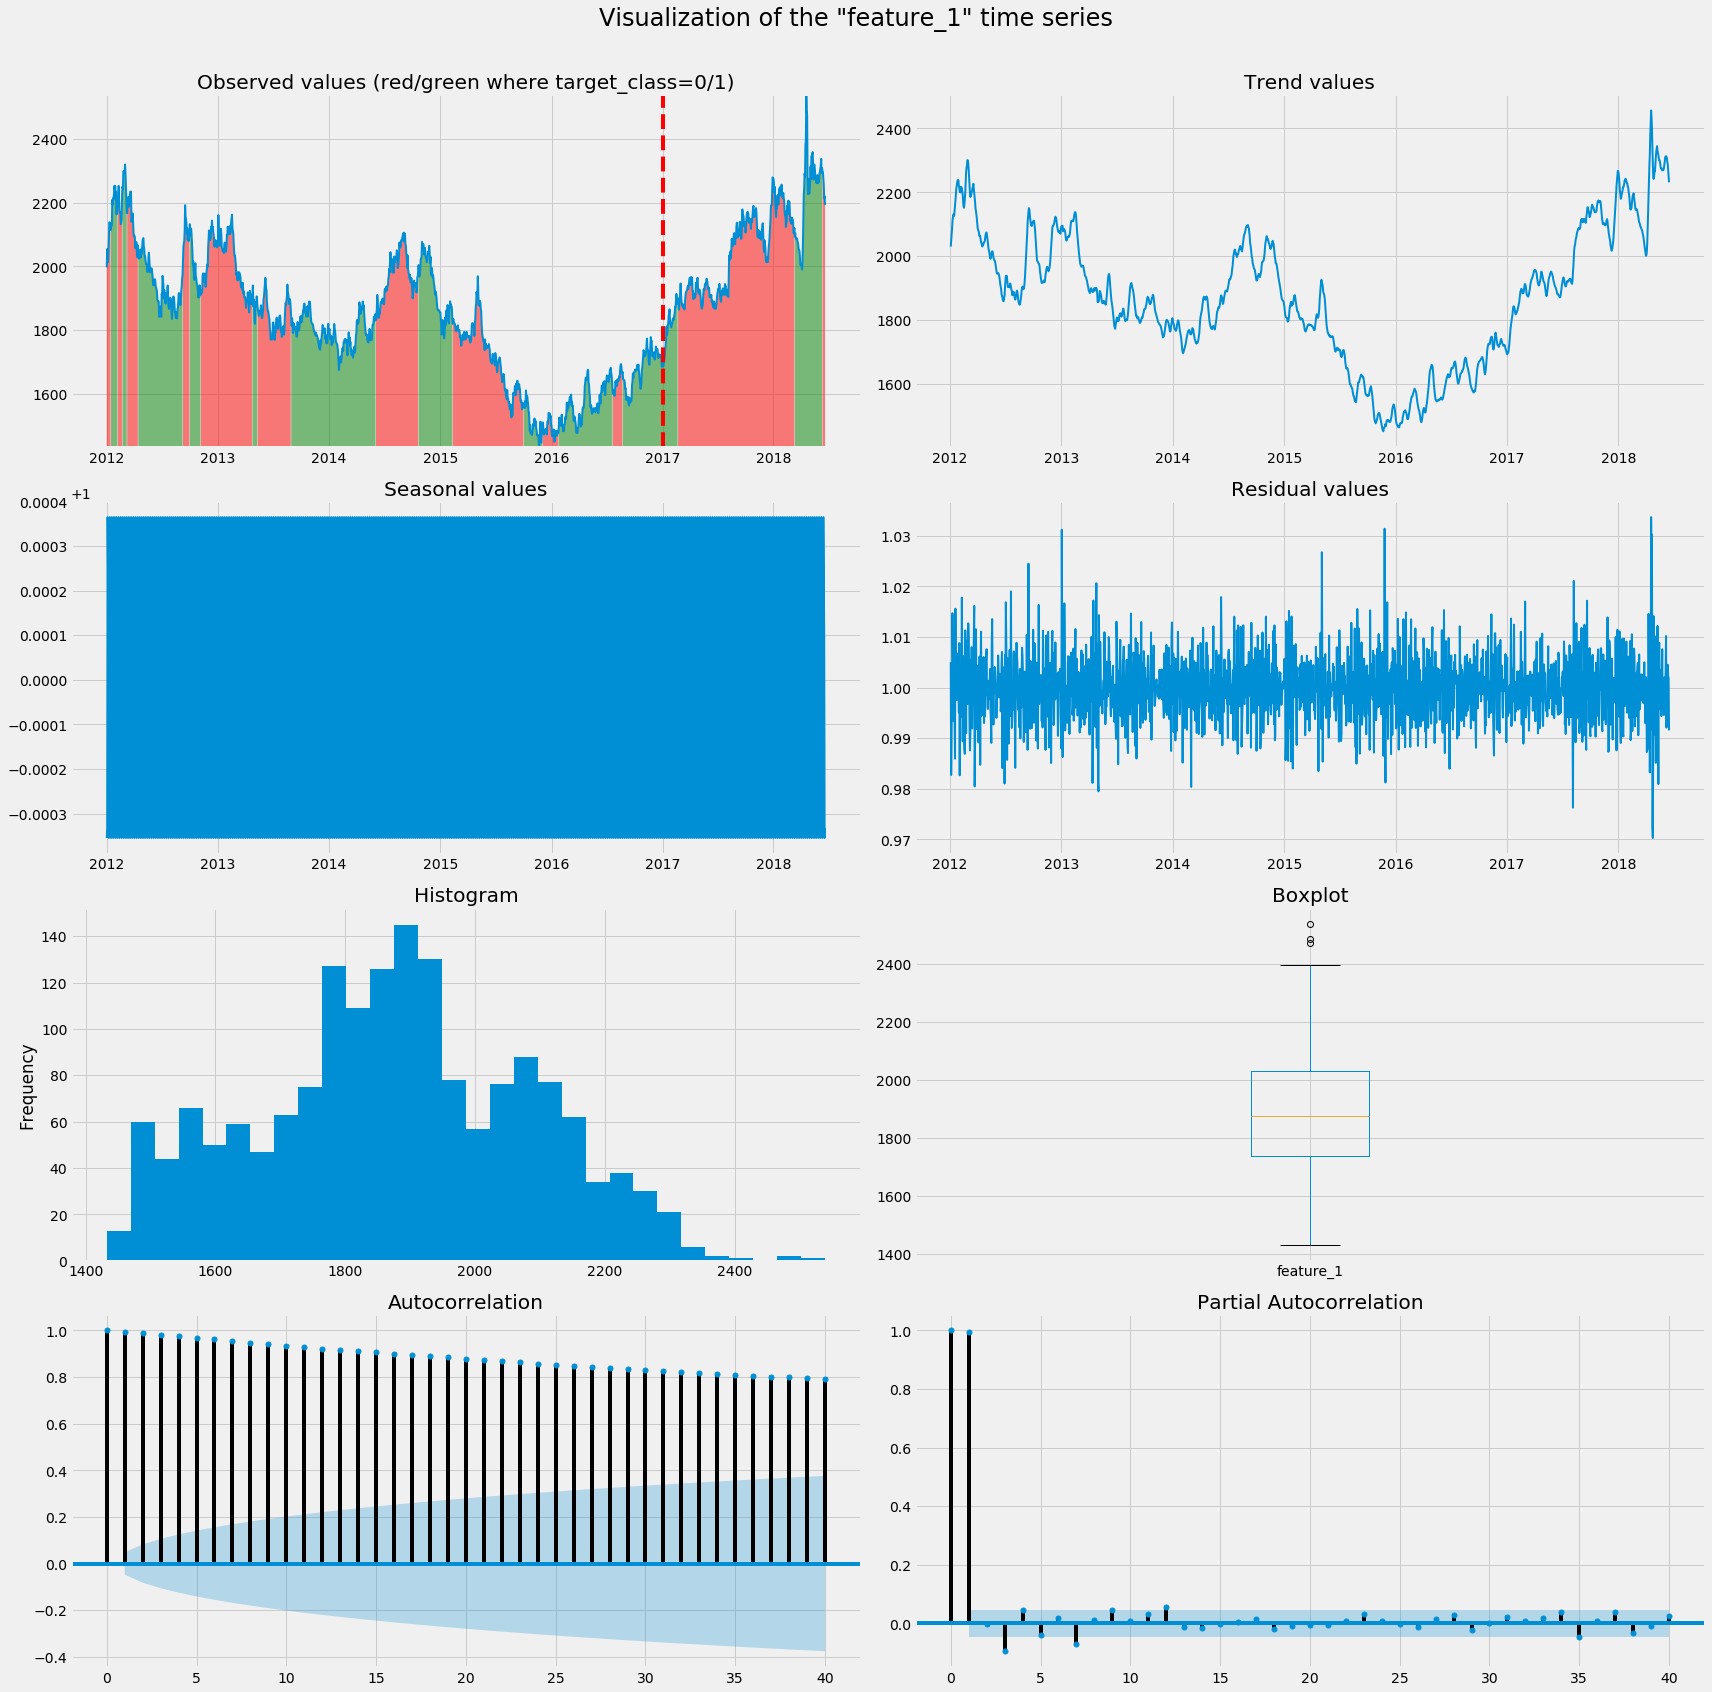

In [44]:
# Call EDA function to explore the time series
eda(df, 'feature_1', 'multiplicative')

# <a name="feature_2"></a> A-2. feature_2
[Back to INDEX](#index)

Statistic of feature_2 time series
count    1687.000000
mean       78.308648
std        28.412734
min        27.880000
25%        51.705000
50%        68.580000
75%       108.395000
max       126.220000
Name: feature_2, dtype: float64


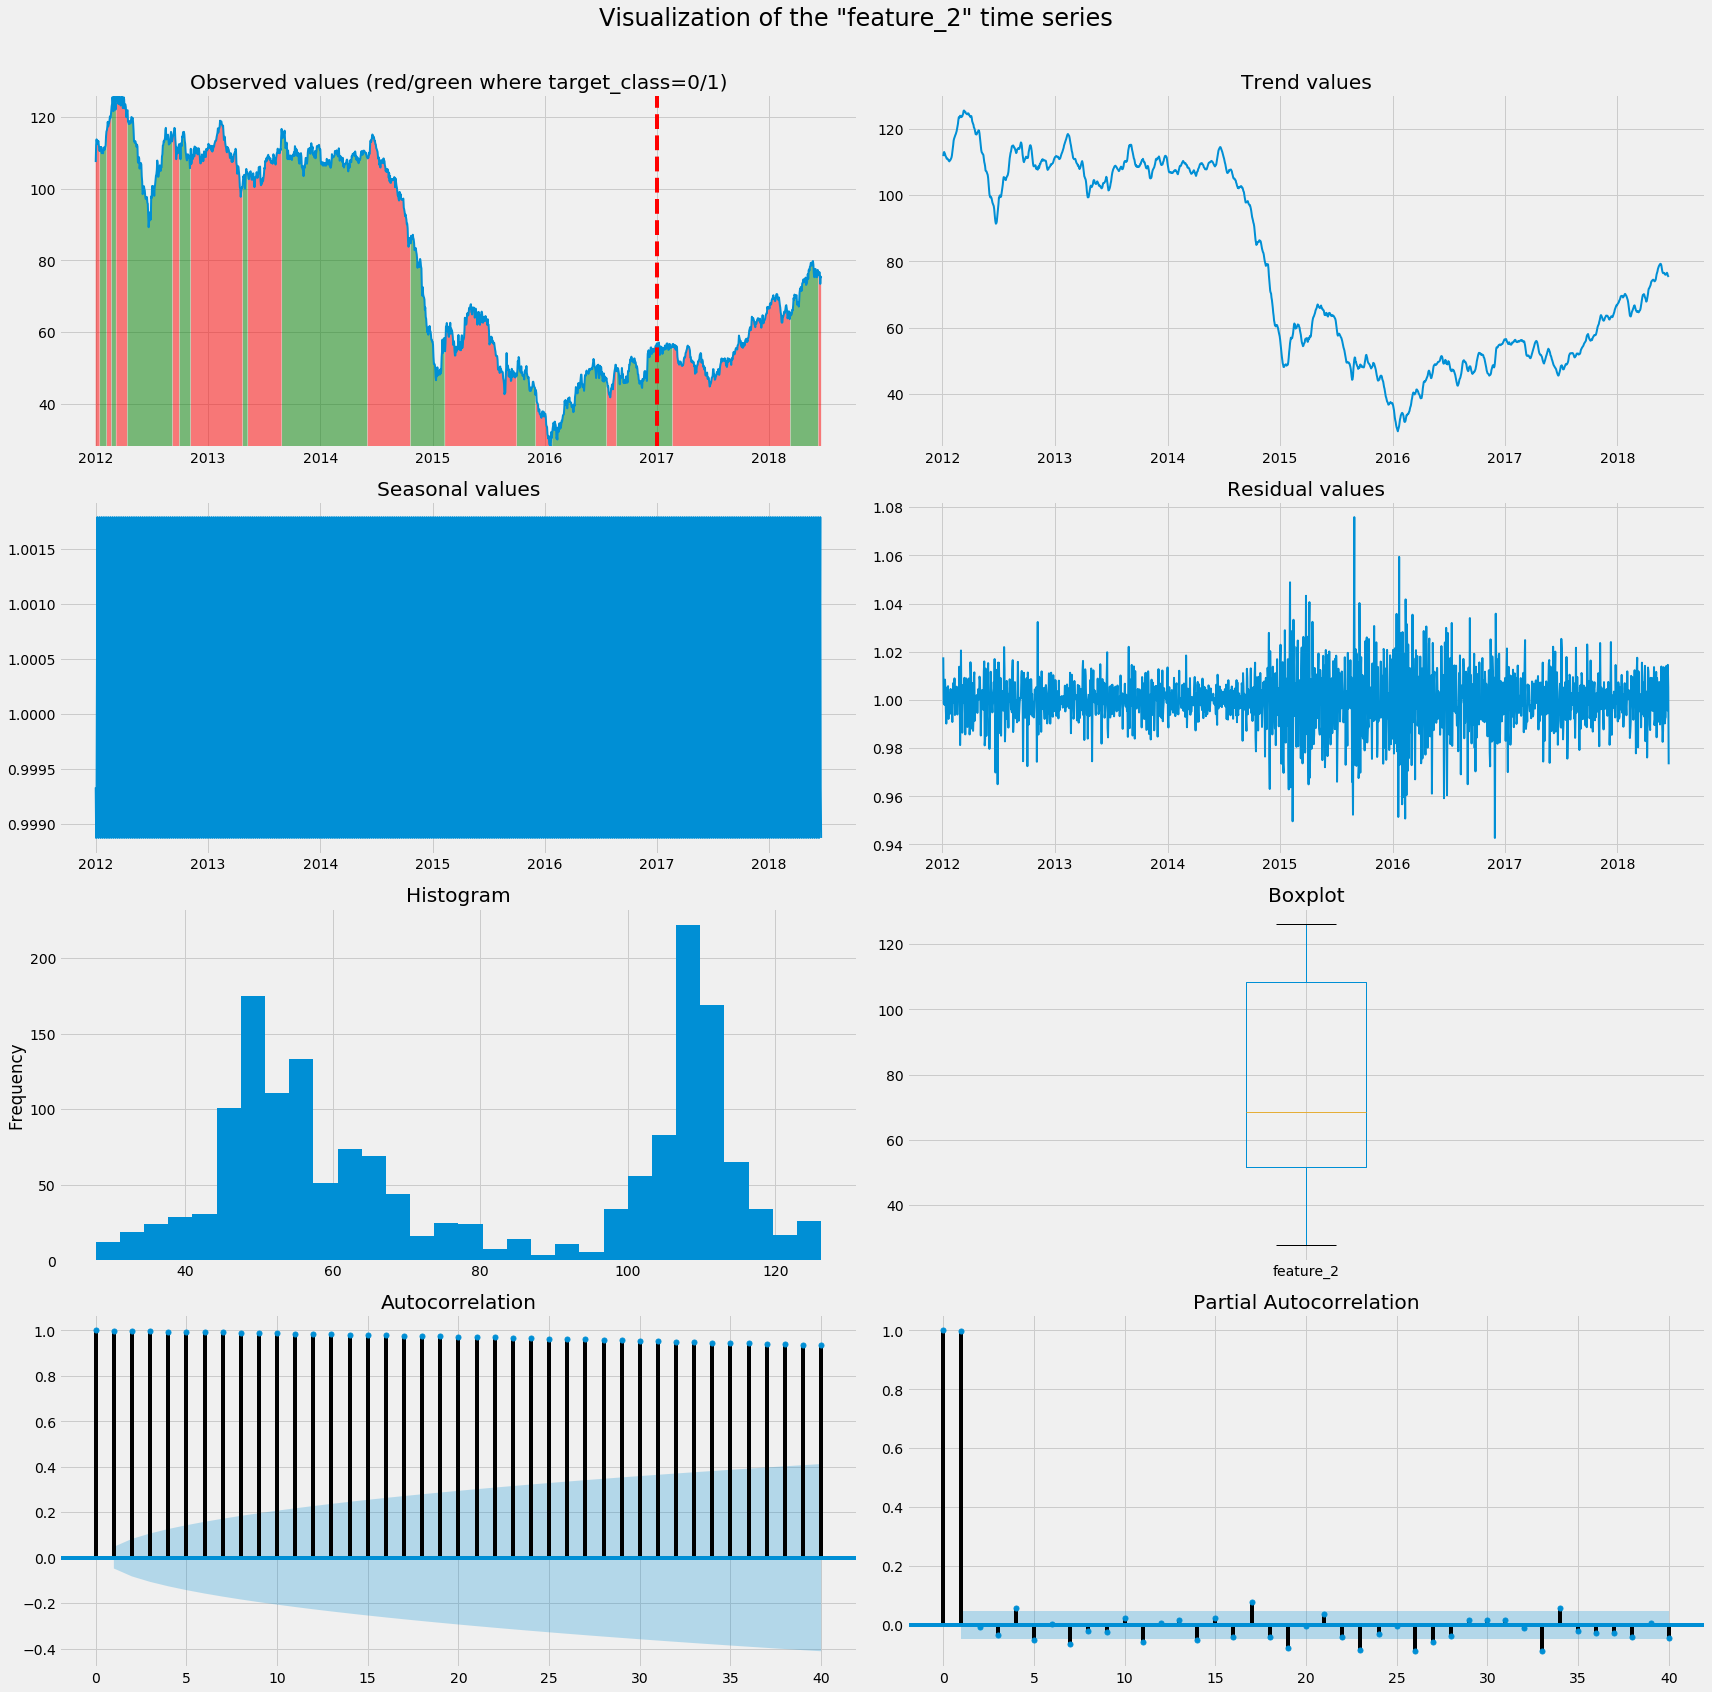

In [45]:
# Call EDA function to explore the time series
eda(df, 'feature_2', 'multiplicative')

# <a name="feature_3"></a> A-3. feature_3
[Back to INDEX](#index)

Statistic of feature_3 time series
count    1687.000000
mean      456.004718
std       136.225121
min       315.250000
25%       361.750000
50%       385.620000
75%       503.250000
max       830.380000
Name: feature_3, dtype: float64


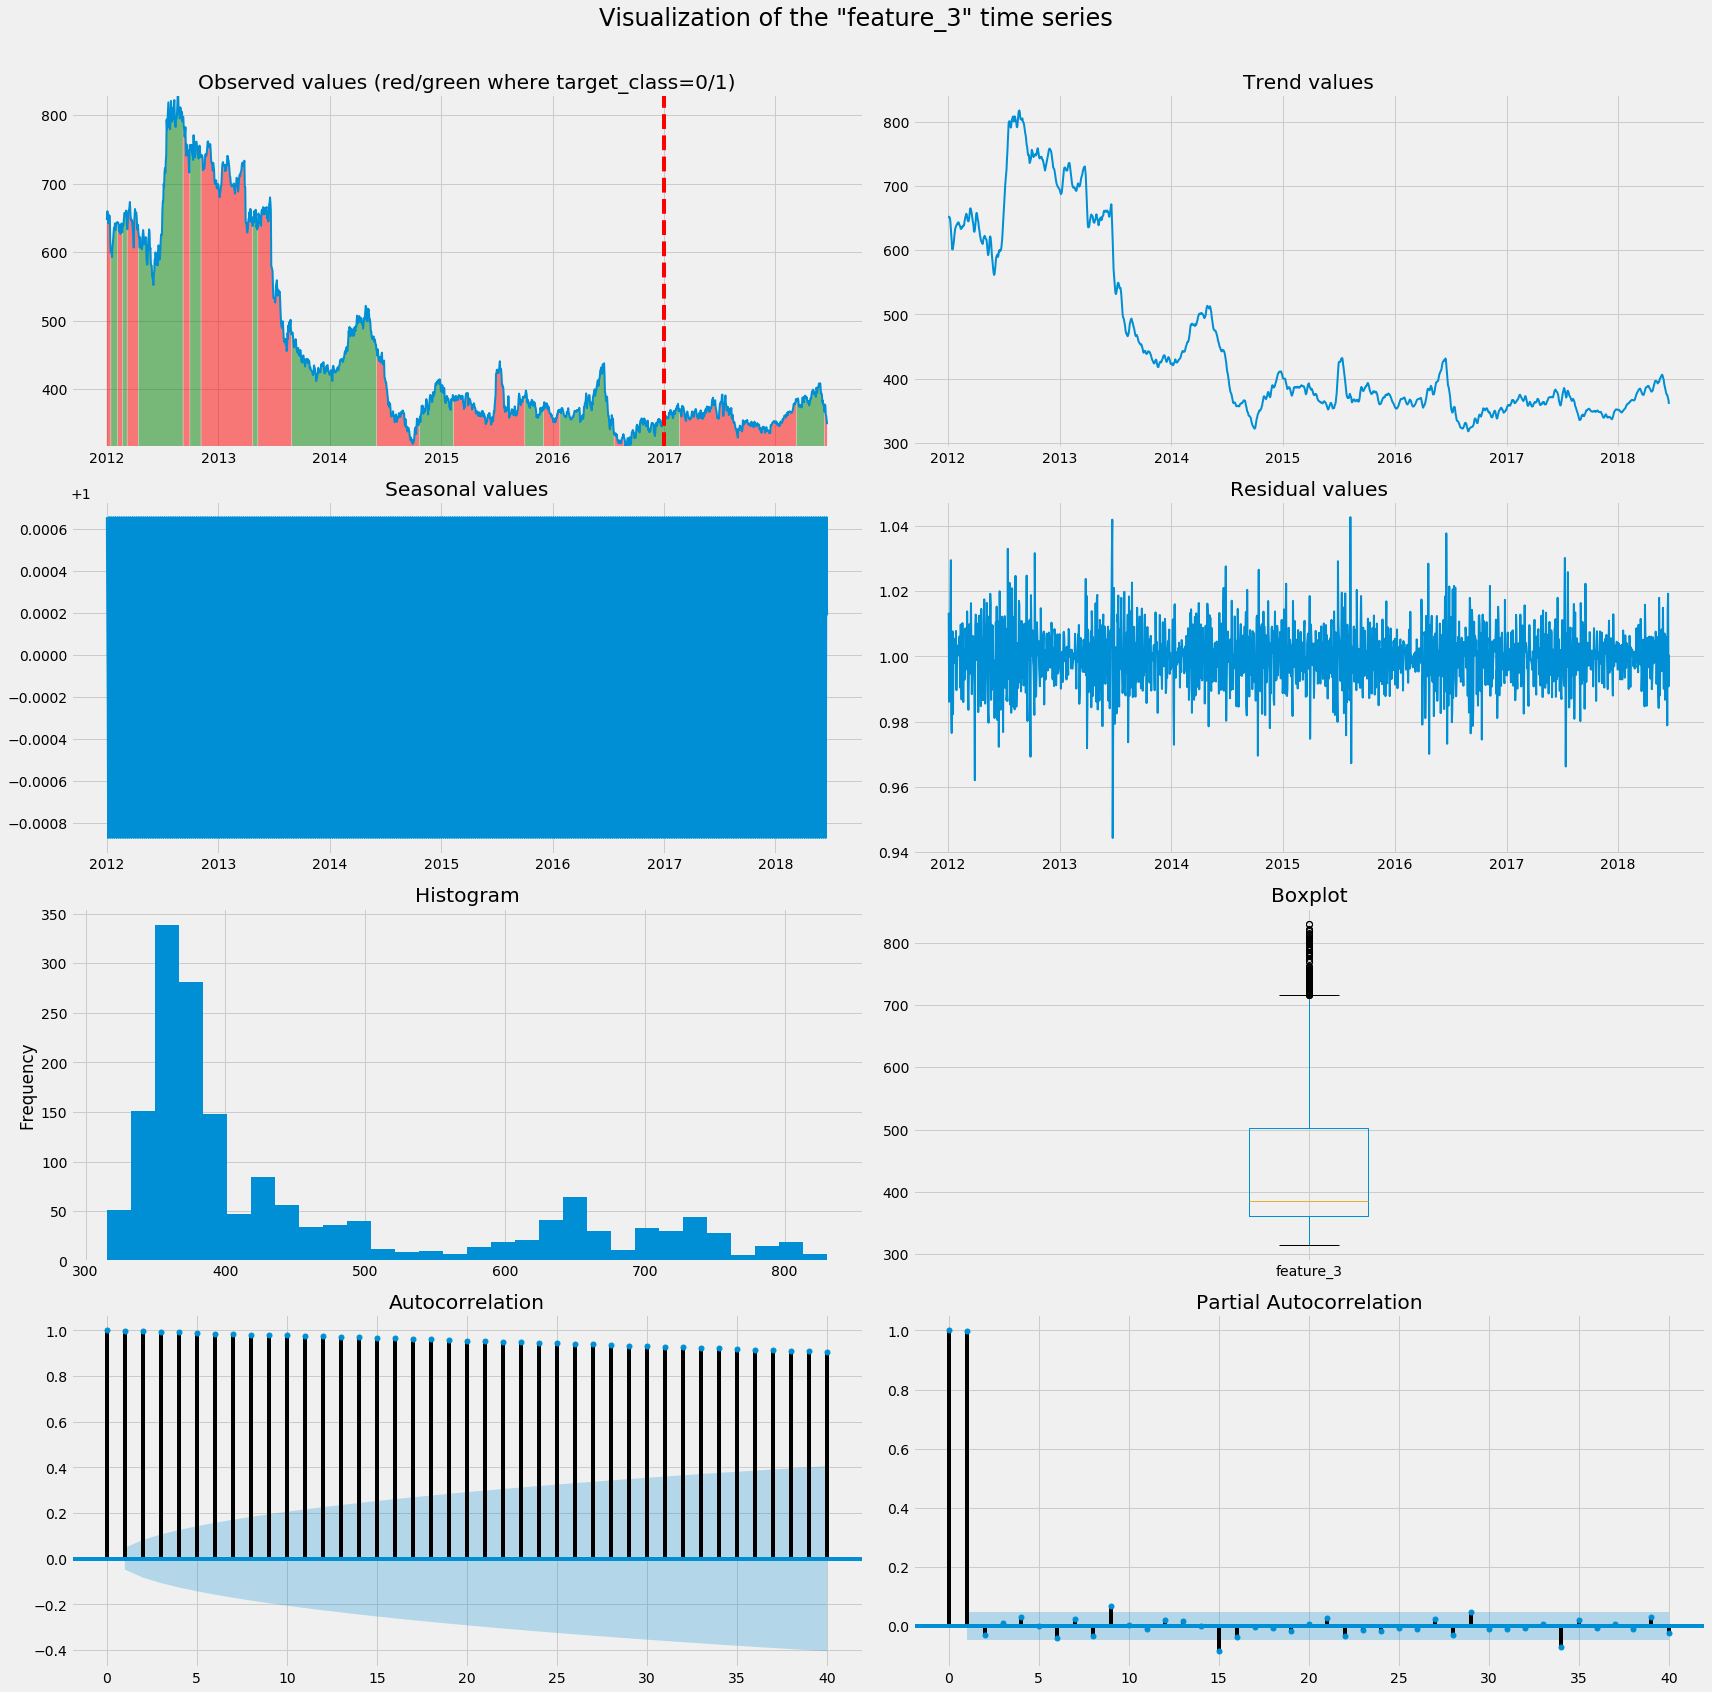

In [46]:
# Call EDA function to explore the time series
eda(df, 'feature_3', 'multiplicative')

# <a name="feature_4"></a> A-4. feature_4
[Back to INDEX](#index)

Statistic of feature_4 time series
count    1687.000000
mean        3.147134
std         0.725657
min         1.639000
25%         2.693000
50%         2.968000
75%         3.629000
max         6.149000
Name: feature_4, dtype: float64


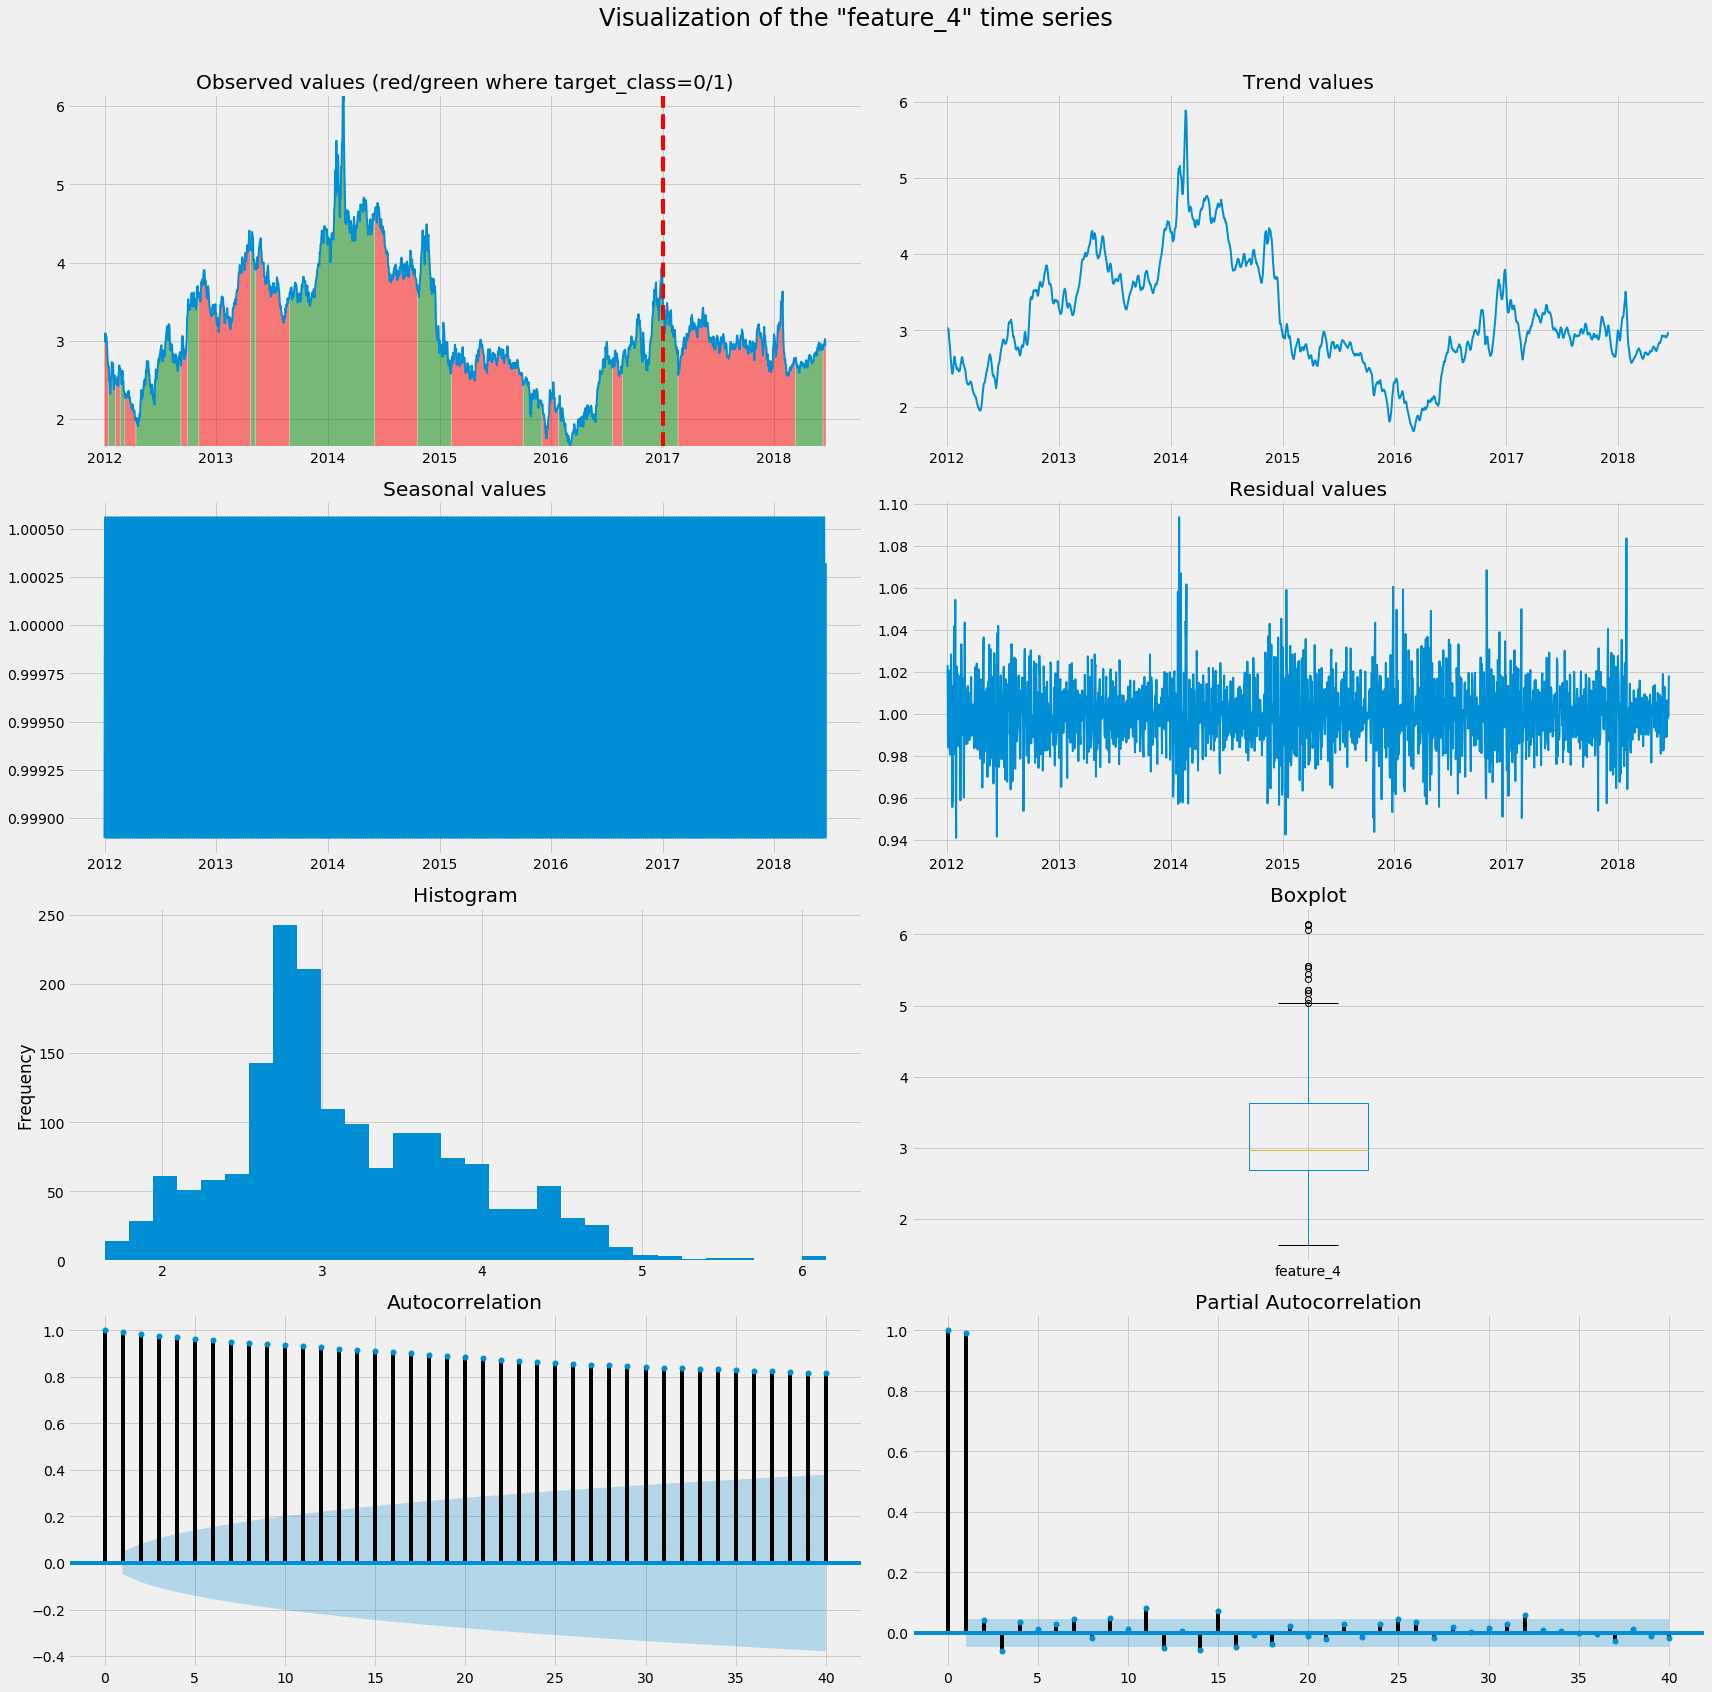

In [47]:
# Call EDA function to explore the time series
eda(df, 'feature_4', 'multiplicative')

# <a name="feature_5"></a> A-5. feature_5
[Back to INDEX](#index)

Statistic of feature_5 time series
count    1687.000000
mean      100.000000
std         0.000006
min        99.999980
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000020
Name: feature_5, dtype: float64


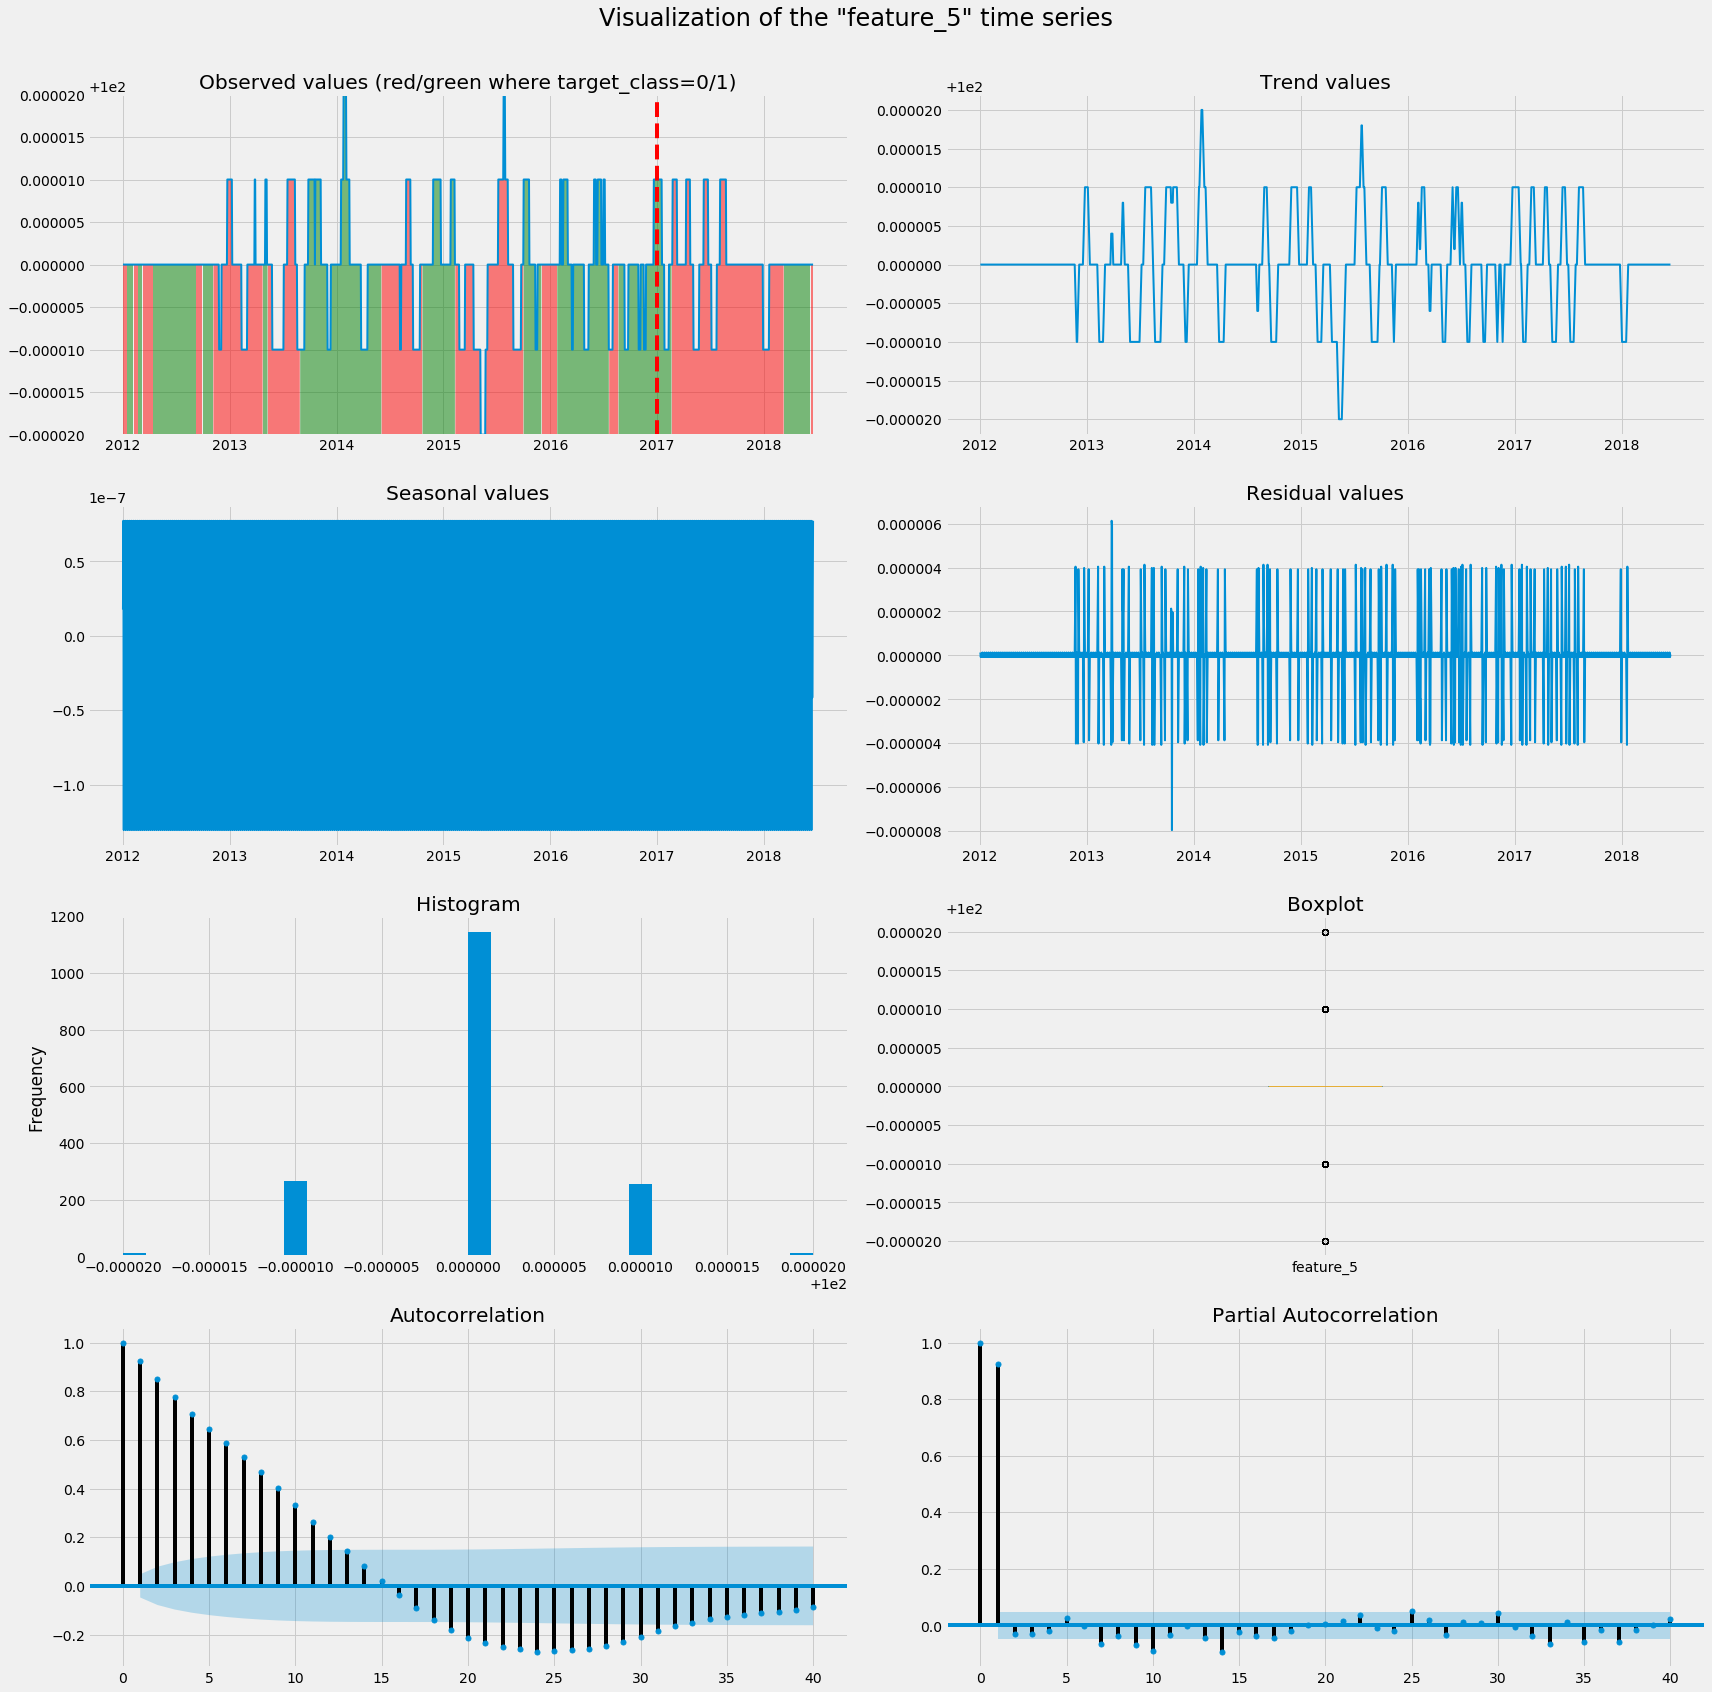

In [48]:
# Call EDA function to explore the time series
eda(df, 'feature_5')

# <a name="feature_6"></a> A-6. feature_6
[Back to INDEX](#index)

Statistic of feature_6 time series
count    1687.000000
mean      100.001655
std         0.017130
min        99.958600
25%        99.988535
50%       100.003080
75%       100.014050
max       100.045650
Name: feature_6, dtype: float64


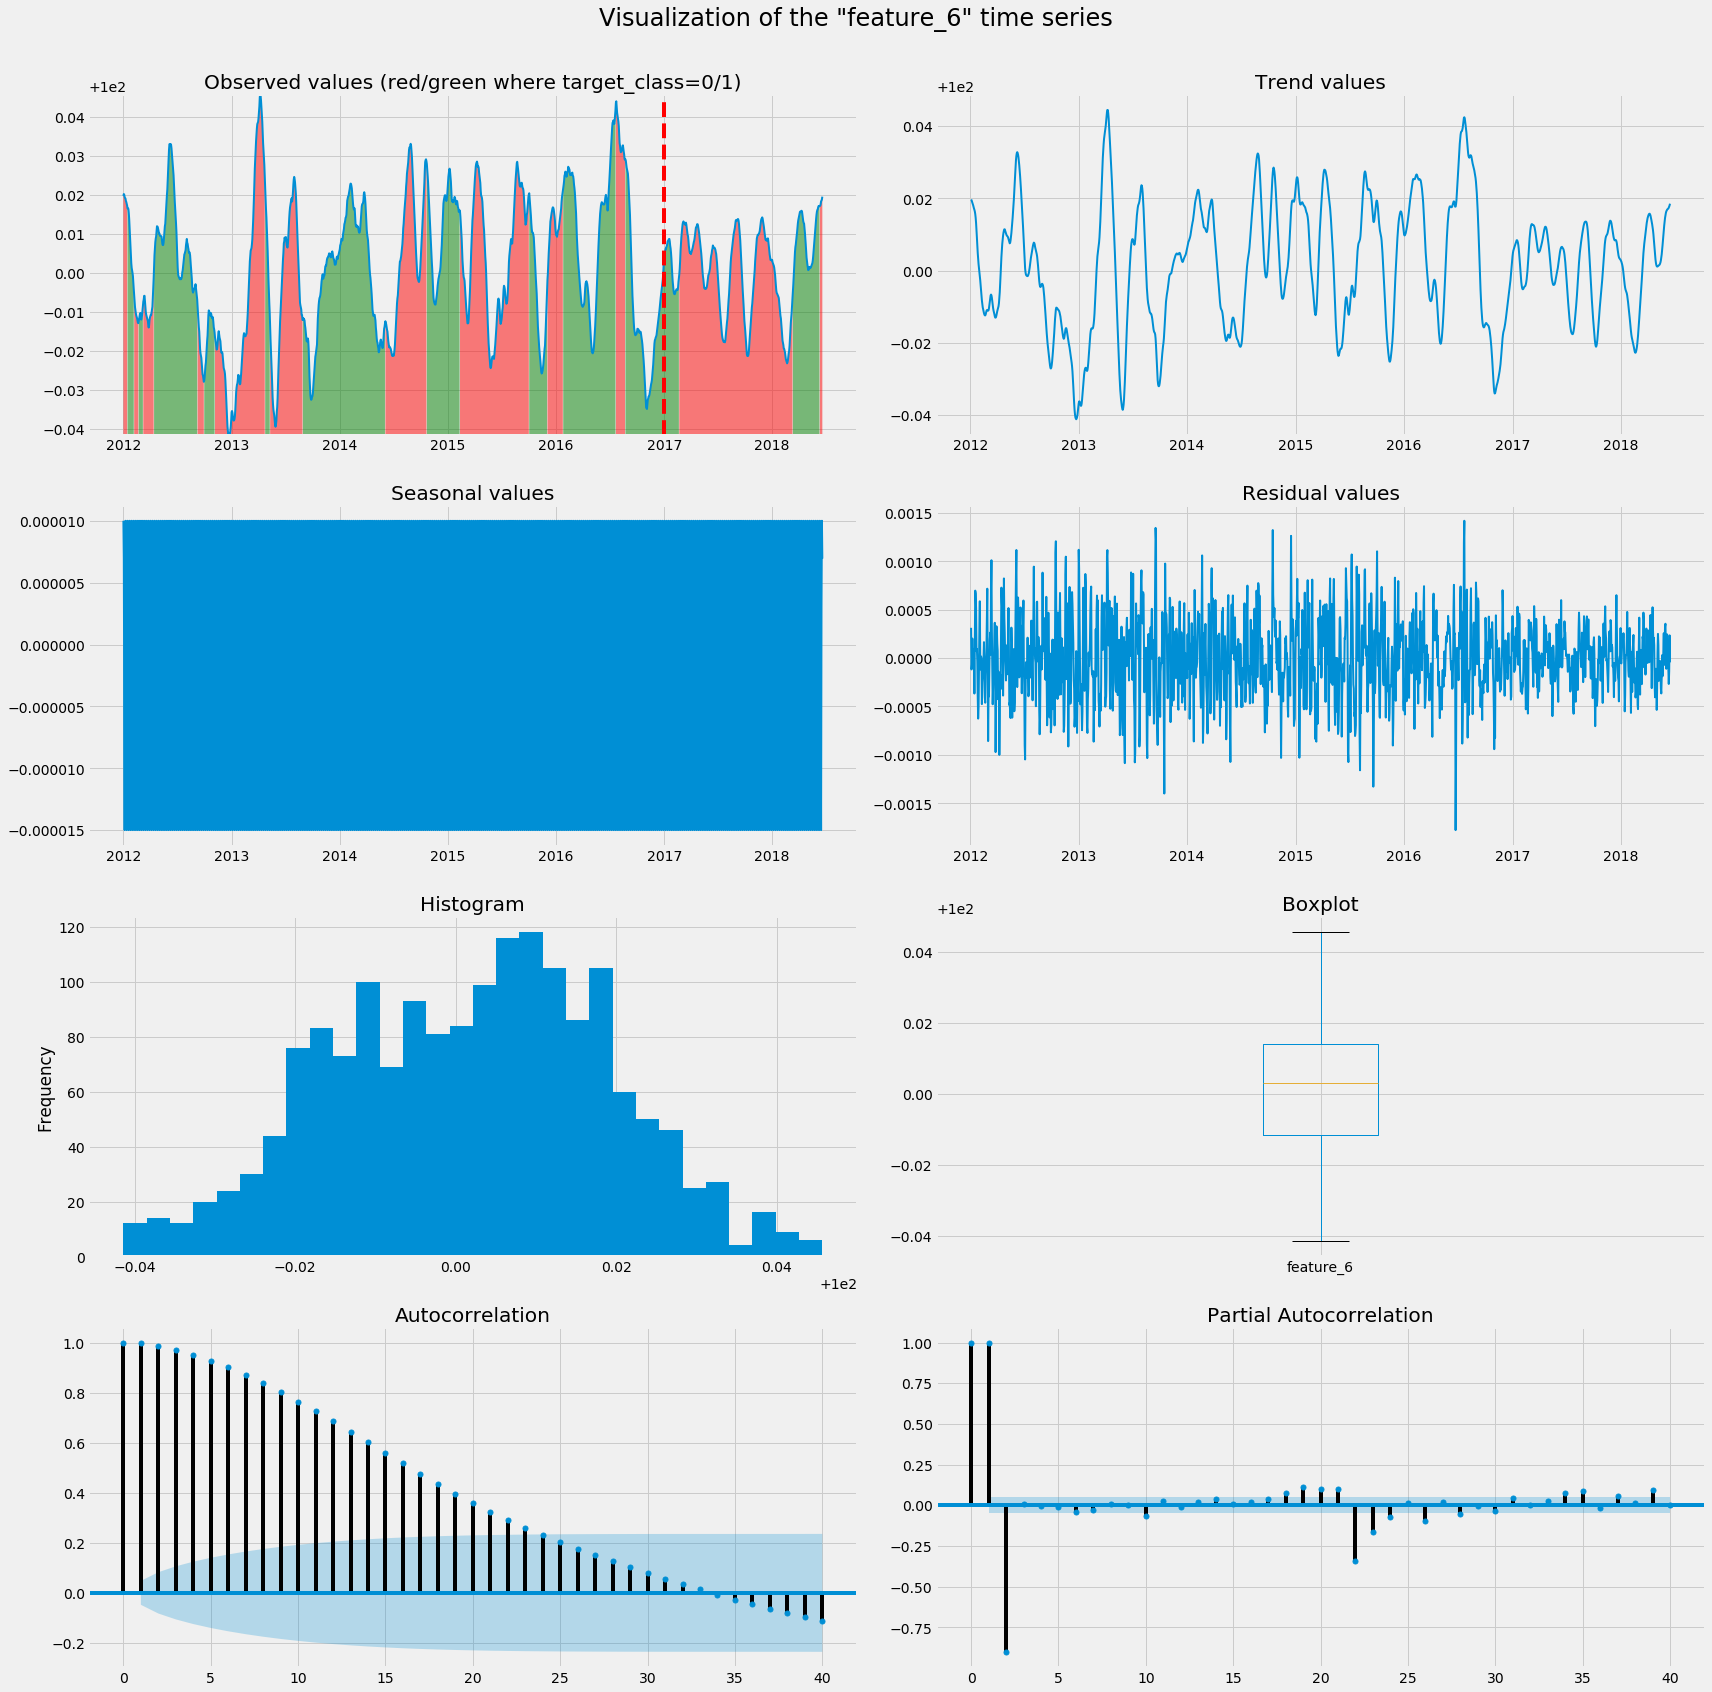

In [49]:
# Call EDA function to explore the time series
eda(df, 'feature_6')

# <a name="feature_7"></a> A-7. feature_7
[Back to INDEX](#index)

Statistic of feature_7 time series
count    1687.000000
mean       99.999139
std         0.010913
min        99.975260
25%        99.992460
50%        99.997900
75%       100.002790
max       100.040210
Name: feature_7, dtype: float64


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


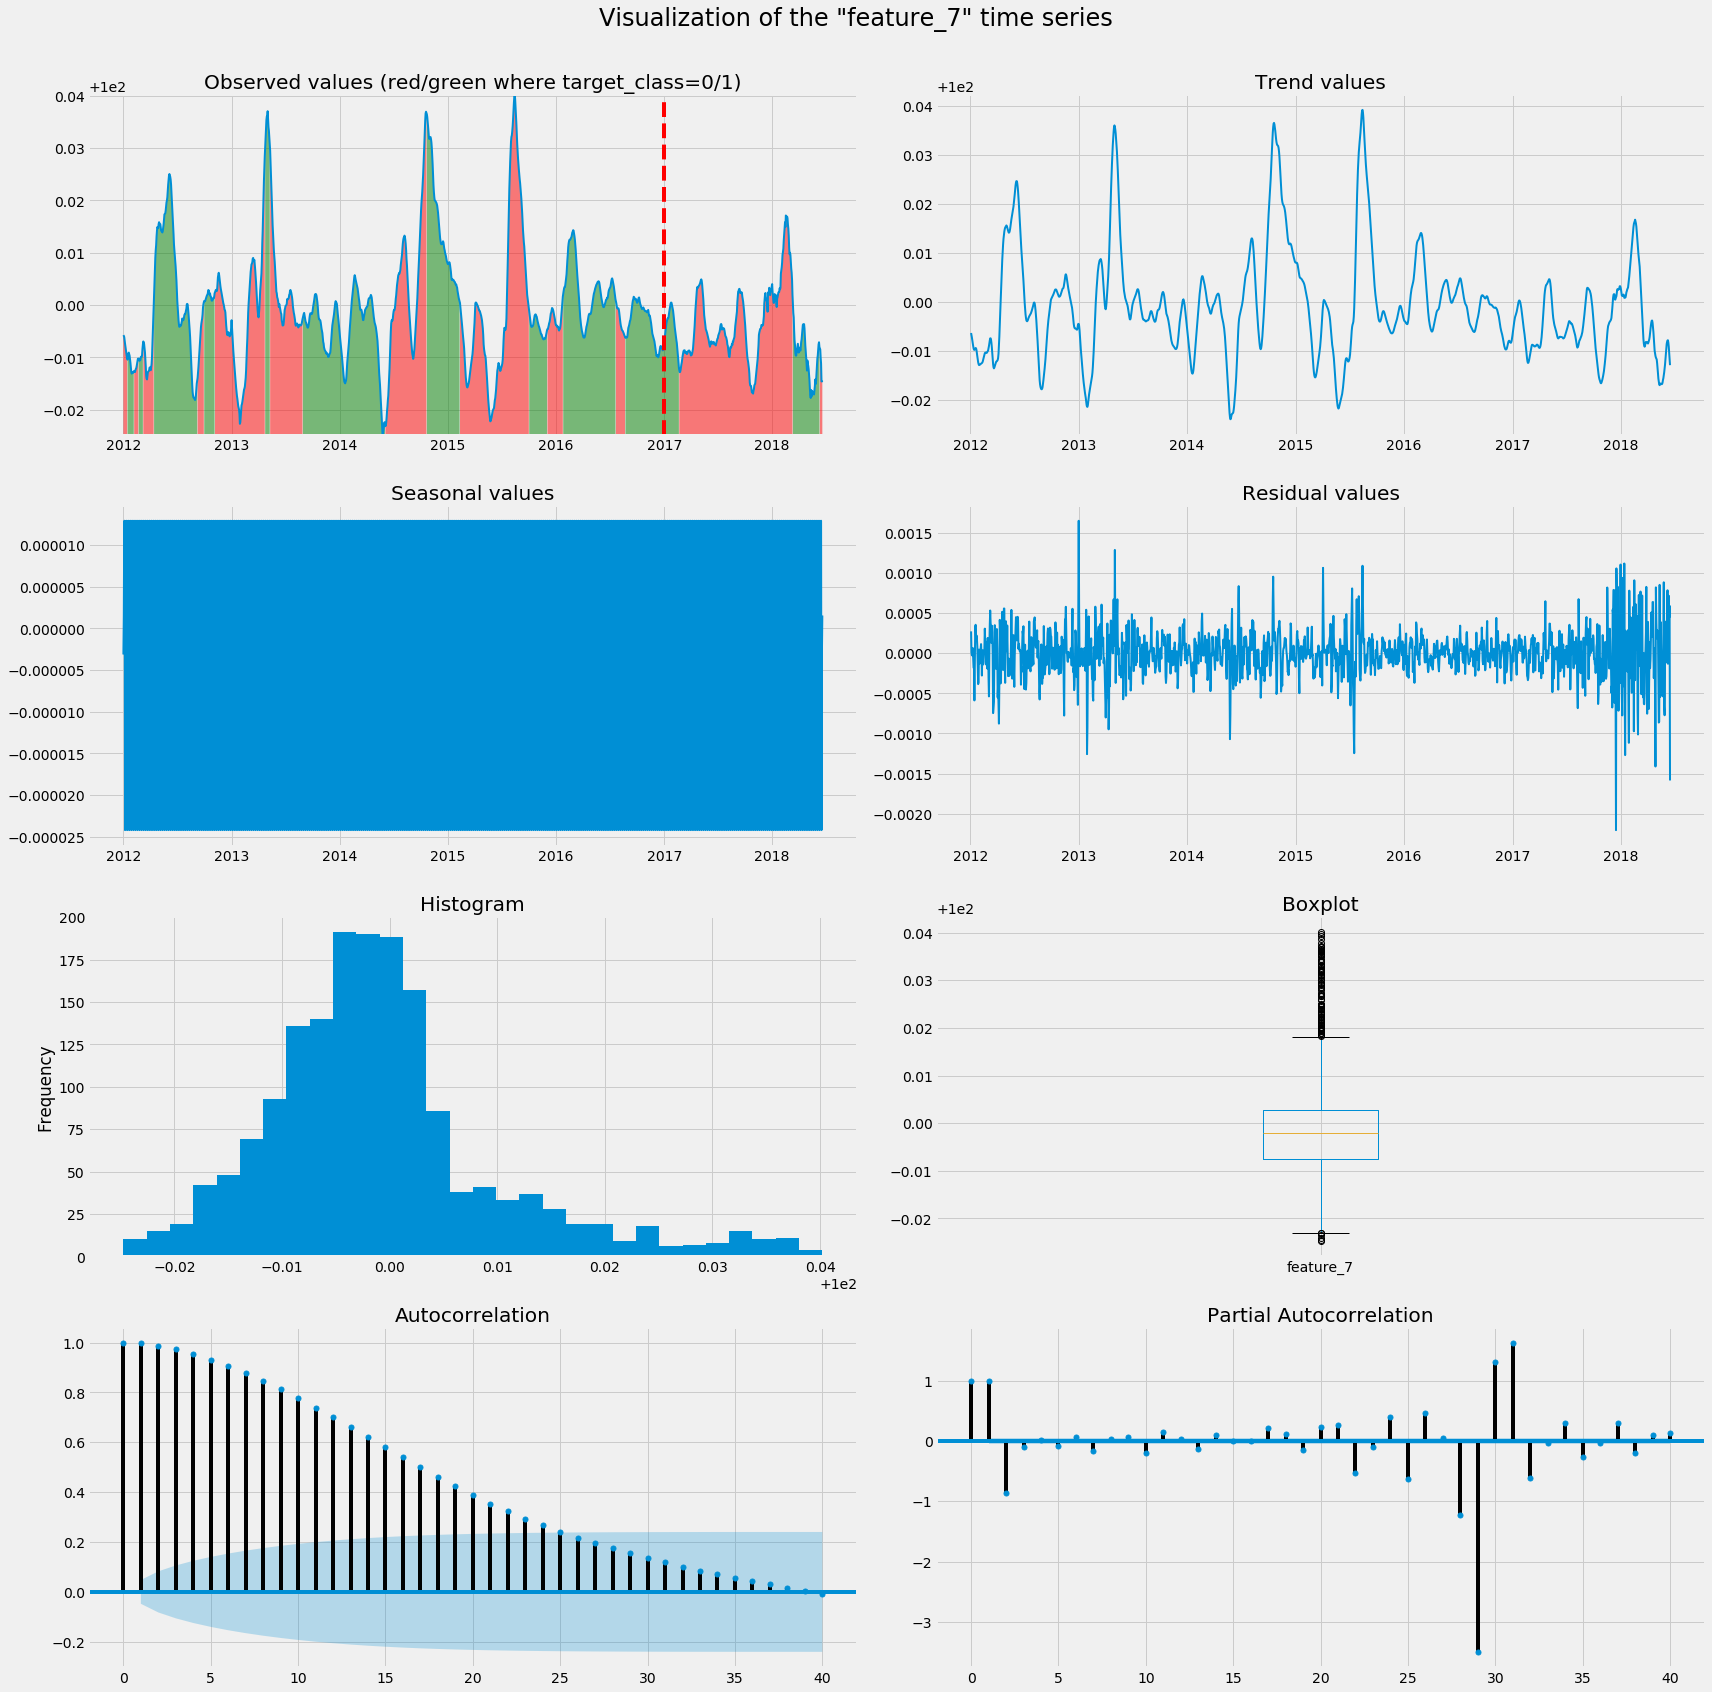

In [50]:
# Call EDA function to explore the time series
eda(df, 'feature_7')

# <a name="feature_8"></a> A-8. feature_8
[Back to INDEX](#index)

Statistic of feature_8 time series
count    1687.000000
mean      106.376068
std        77.335033
min      -340.341959
25%        99.837080
50%       100.010800
75%       100.212422
max       780.009937
Name: feature_8, dtype: float64


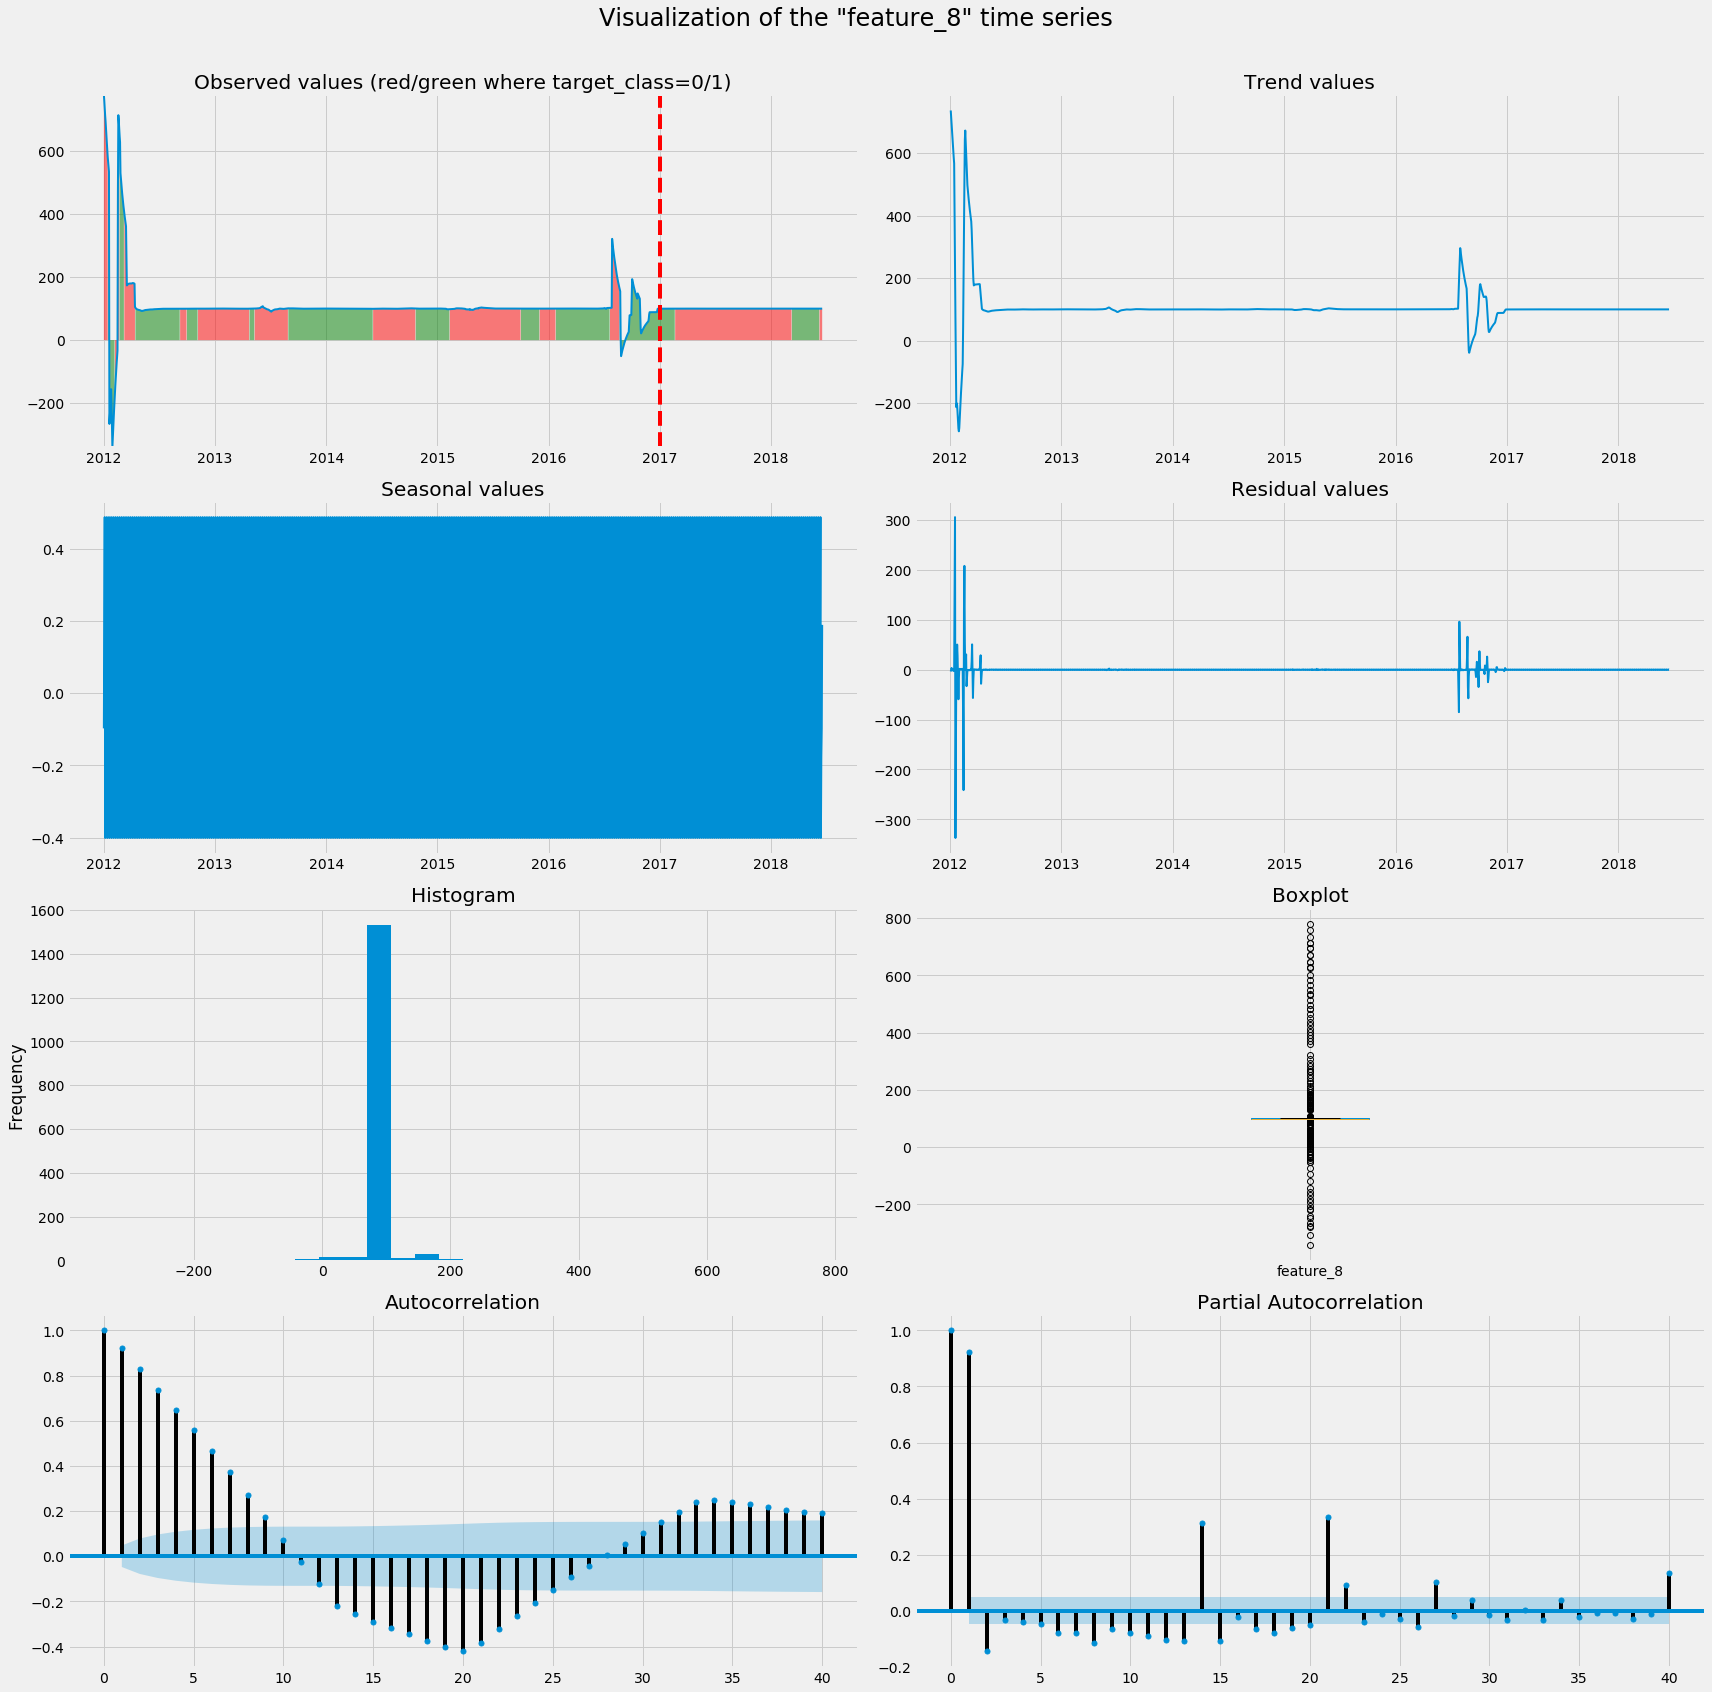

In [51]:
# Call EDA function to explore the time series
eda(df, 'feature_8')

# <a name="feature_9"></a> A-9. feature_9
[Back to INDEX](#index)

Statistic of feature_9 time series
count    1687.000000
mean      118.186766
std       416.394281
min     -3413.280000
25%        98.670705
50%       100.065050
75%       101.033350
max      2626.440000
Name: feature_9, dtype: float64


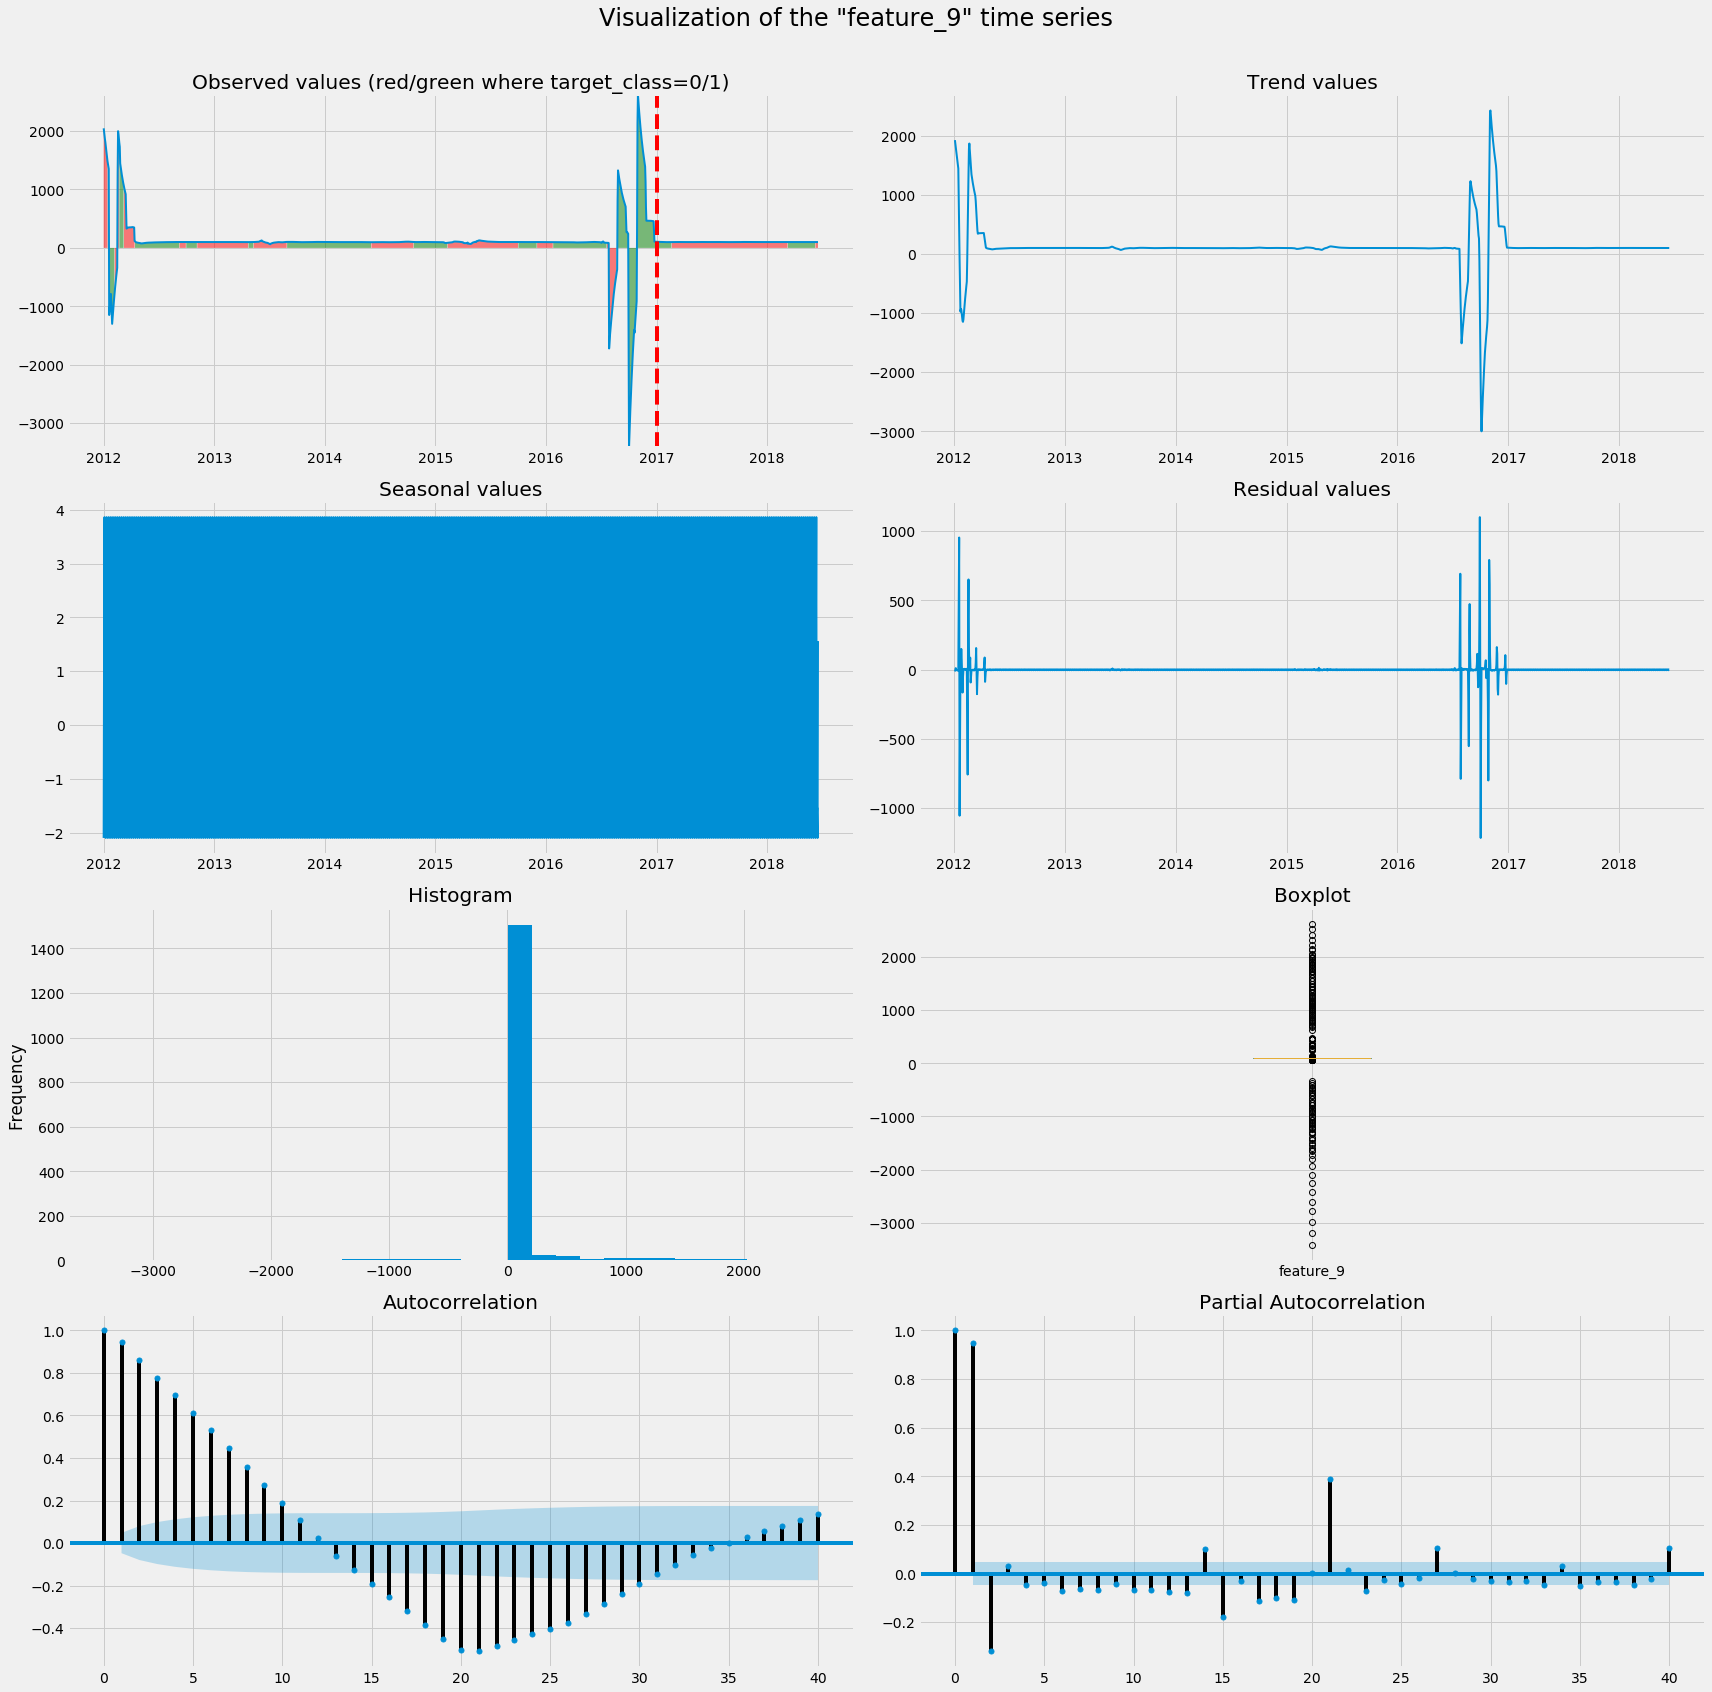

In [52]:
# Call EDA function to explore the time series
eda(df, 'feature_9')

# <a name="feature_10"></a> A-10. feature_10
[Back to INDEX](#index)

Statistic of feature_10 time series
count    1687.000000
mean      119.725374
std       324.174677
min     -2104.320000
25%        98.825686
50%       100.067772
75%       100.879678
max      2206.400000
Name: feature_10, dtype: float64


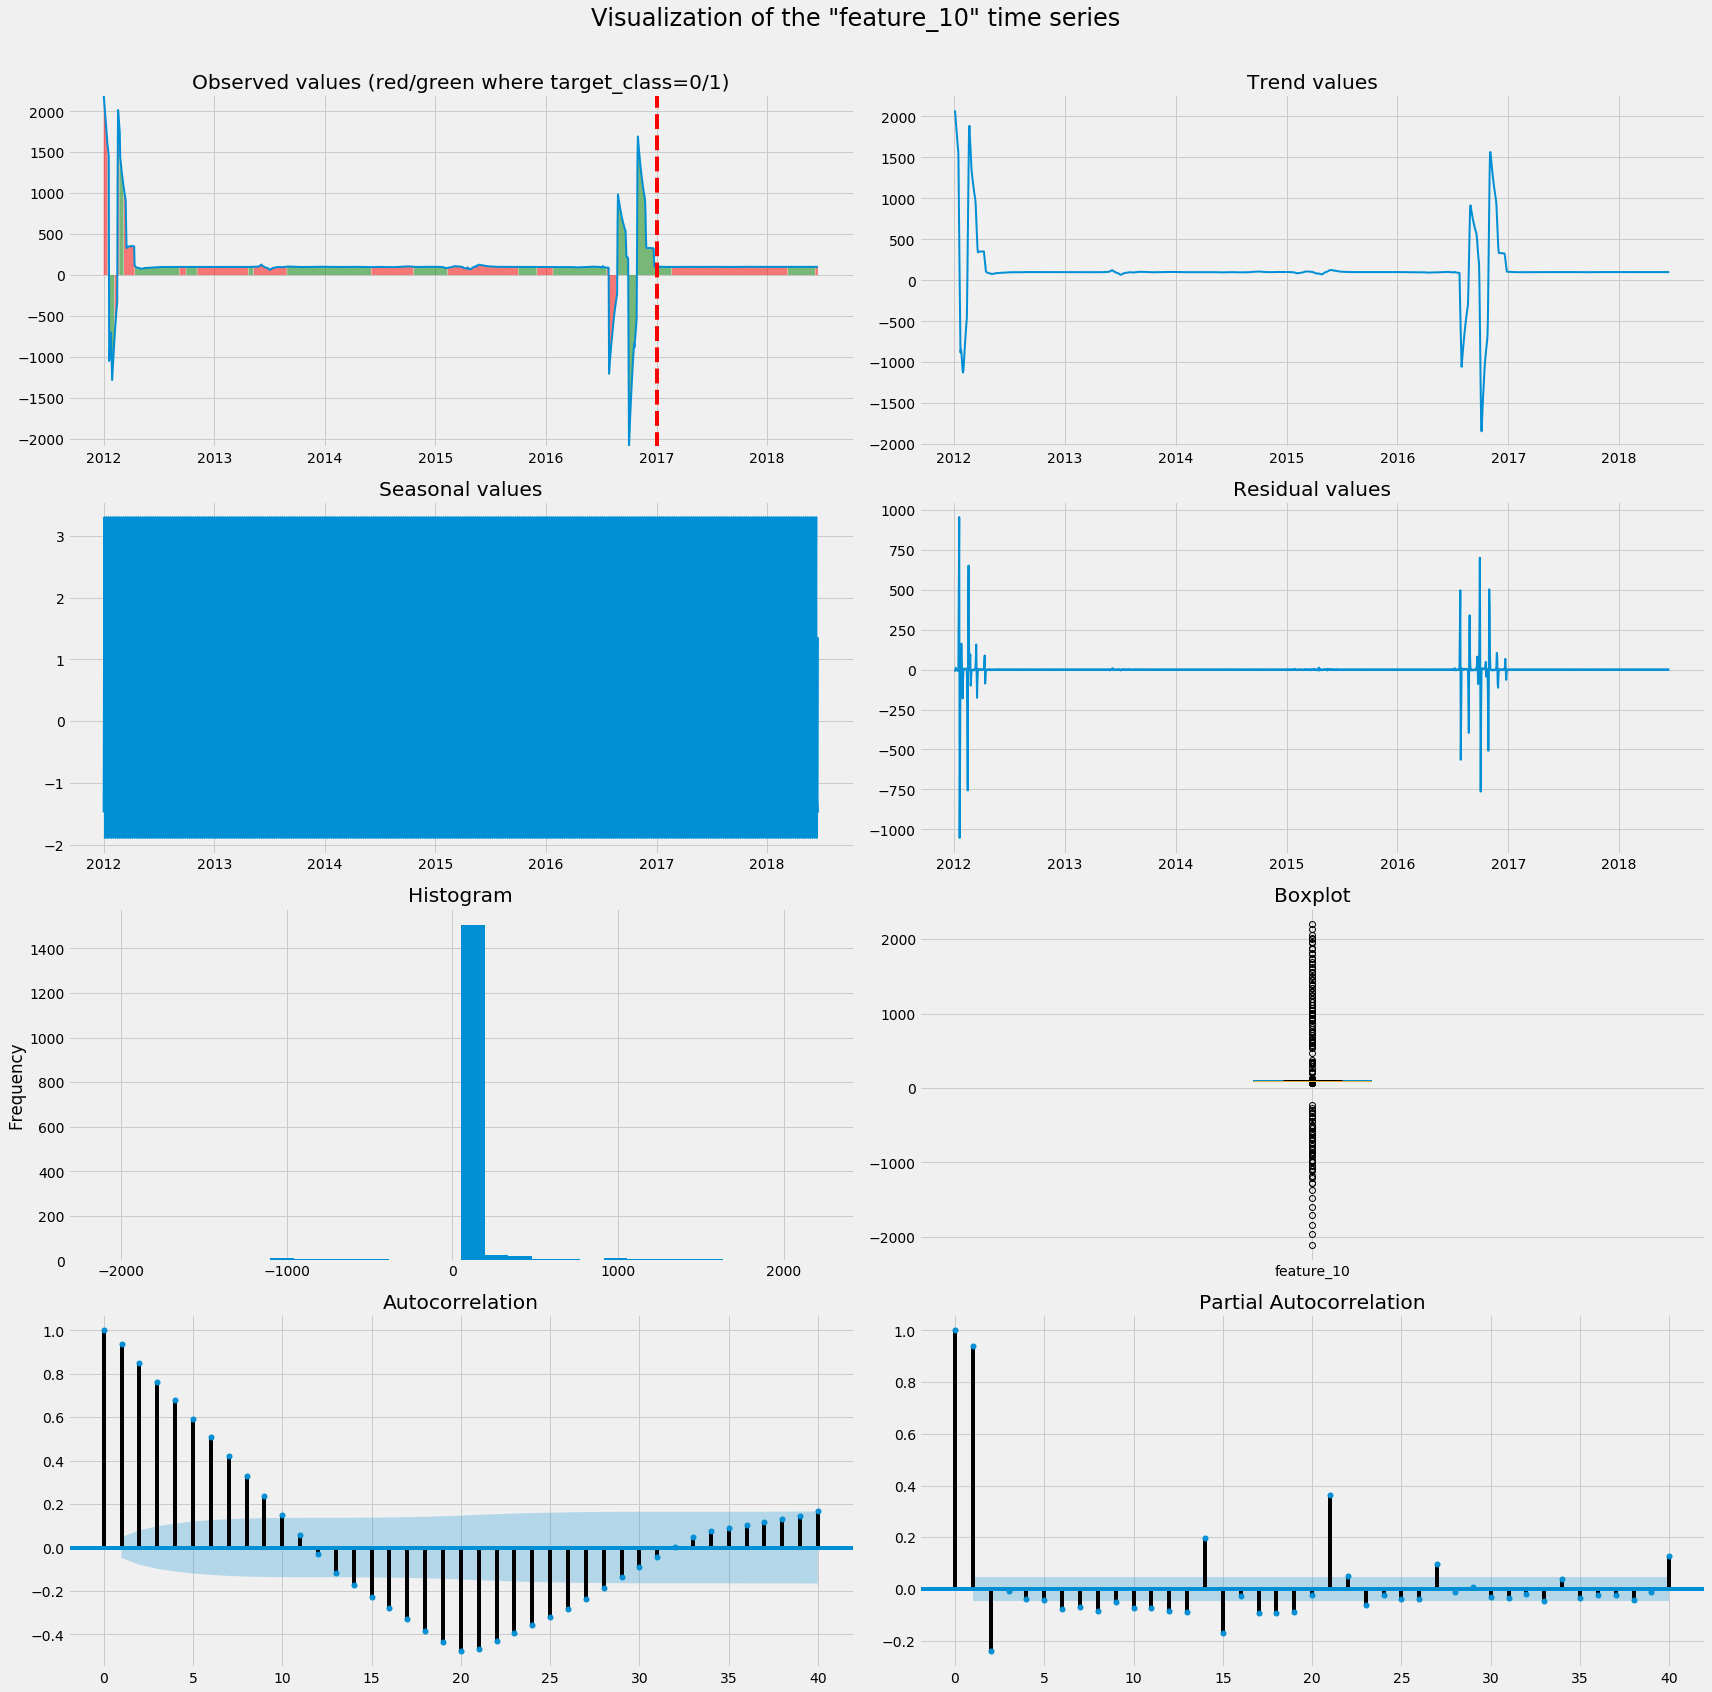

In [53]:
# Call EDA function to explore the time series
eda(df, 'feature_10')

# <a name="feature_11"></a> A-11. feature_11
[Back to INDEX](#index)

Statistic of feature_11 time series
count    1687.000000
mean      100.003464
std       154.915843
min     -1321.160000
25%        99.992350
50%       100.006112
75%       100.016624
max      1213.240000
Name: feature_11, dtype: float64


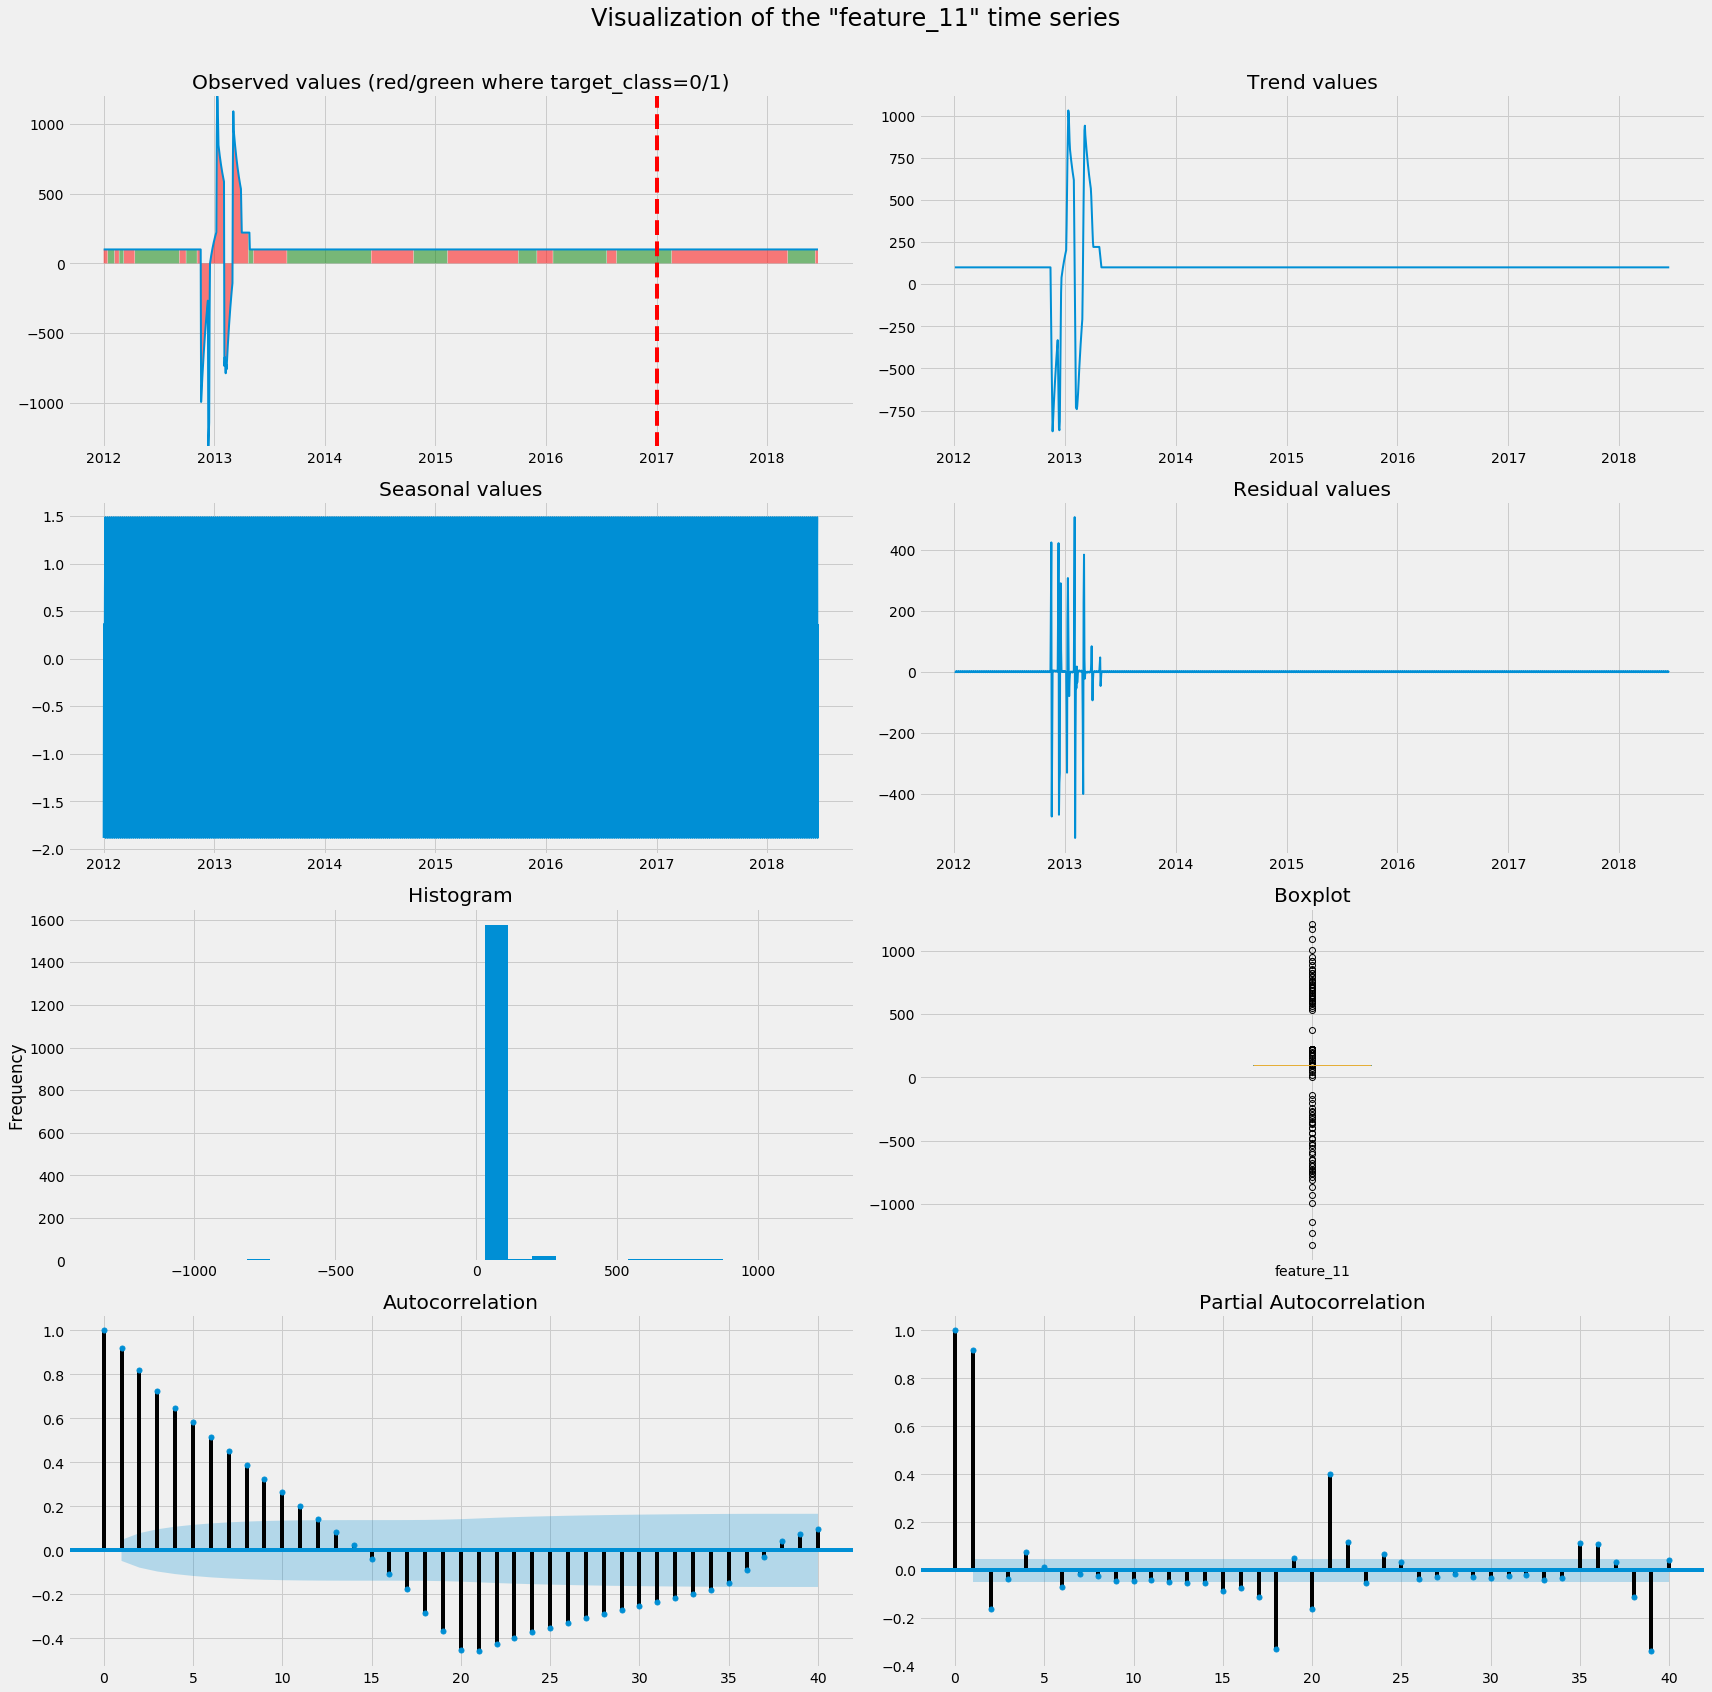

In [54]:
# Call EDA function to explore the time series
eda(df, 'feature_11')

# <a name="feature_12"></a> A-12. feature_12
[Back to INDEX](#index)

Statistic of feature_12 time series
count    1687.000000
mean      100.000858
std       314.711890
min     -2933.570000
25%        99.988280
50%       100.001230
75%       100.017190
max      2462.330000
Name: feature_12, dtype: float64


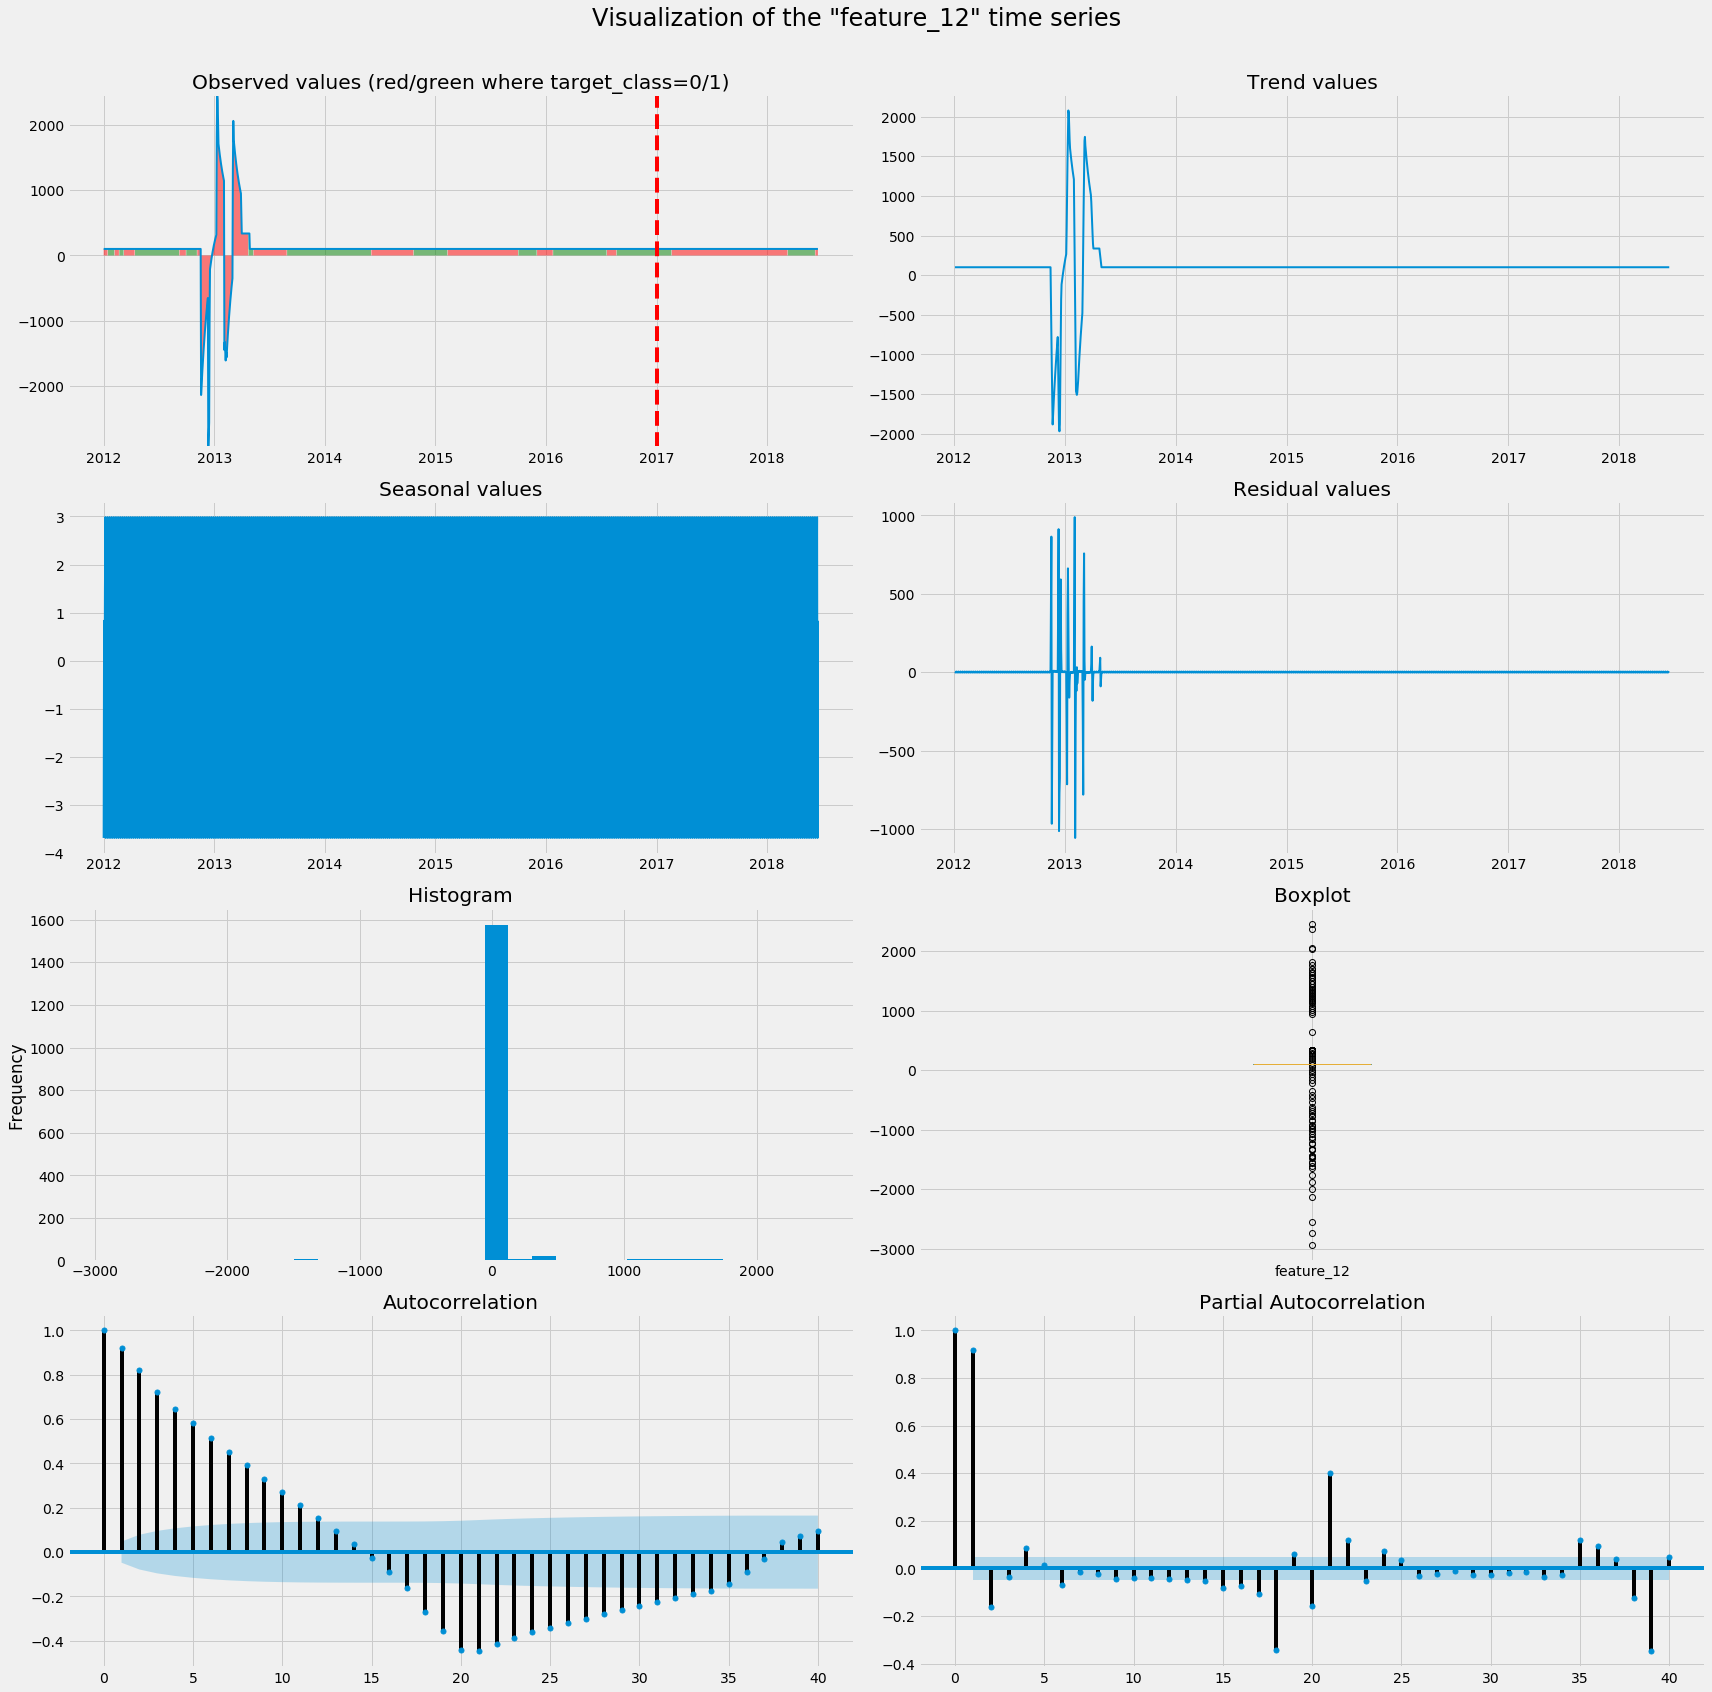

In [55]:
# Call EDA function to explore the time series
eda(df, 'feature_12')

# <a name="feature_13"></a> A-13. feature_13
[Back to INDEX](#index)

Statistic of feature_13 time series
count    1687.000000
mean      100.003531
std       338.136106
min     -3206.010000
25%        99.989090
50%       100.005710
75%       100.019640
max      2678.710000
Name: feature_13, dtype: float64


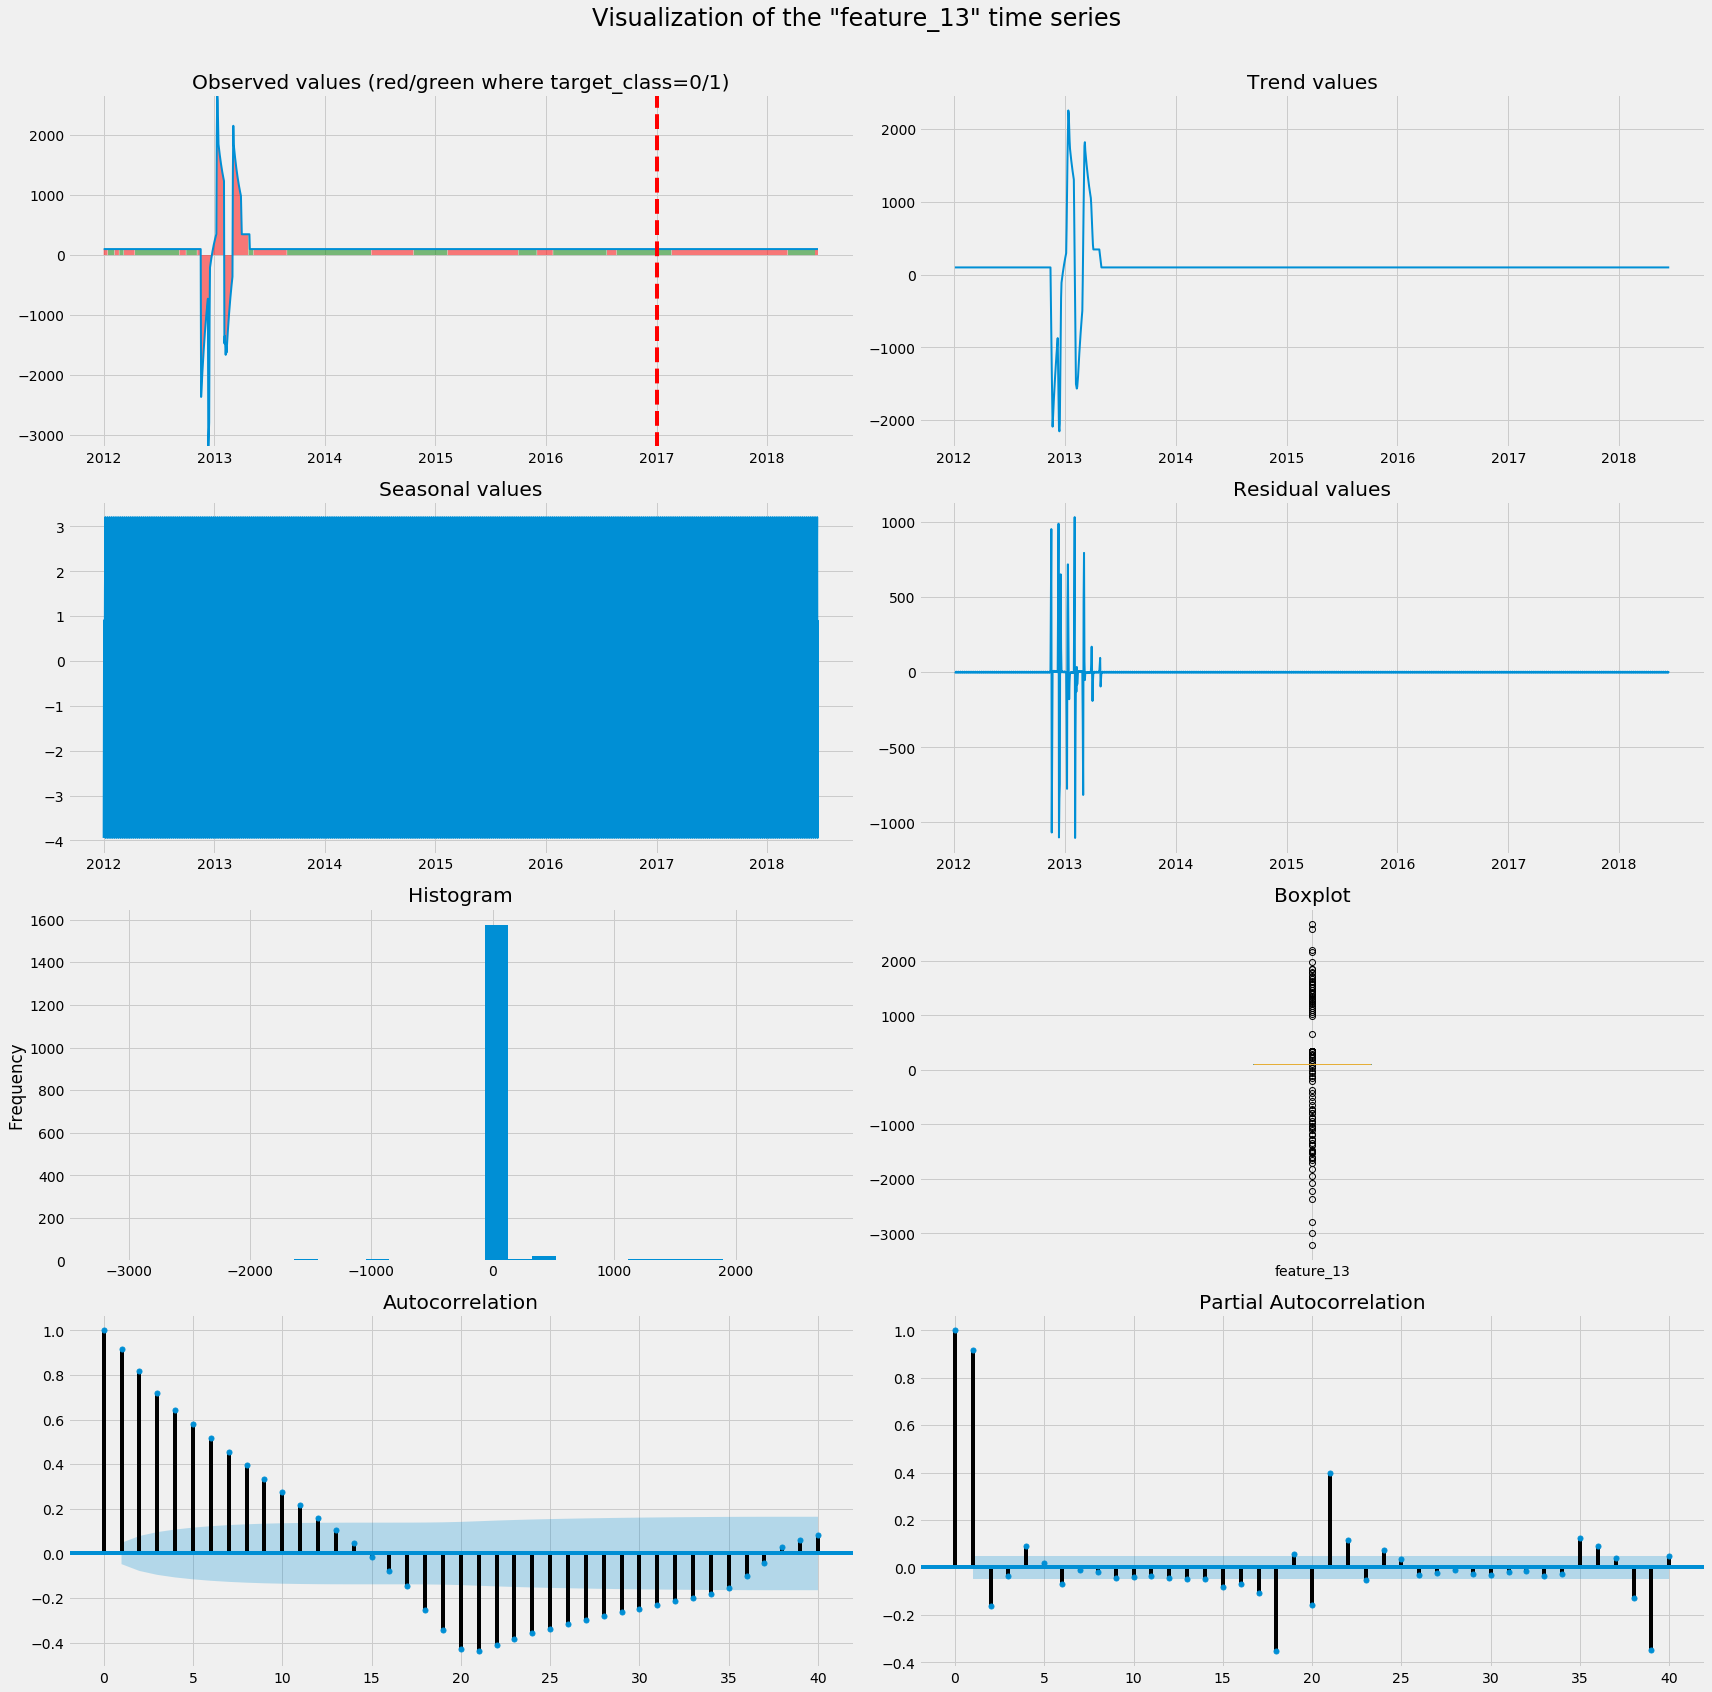

In [56]:
# Call EDA function to explore the time series
eda(df, 'feature_13')

# <a name="feature_14"></a> A-14. feature_14
[Back to INDEX](#index)

Statistic of feature_14 time series
count    1687.000000
mean      100.000267
std         0.006999
min        99.981590
25%        99.995920
50%        99.999820
75%       100.003575
max       100.029420
Name: feature_14, dtype: float64


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


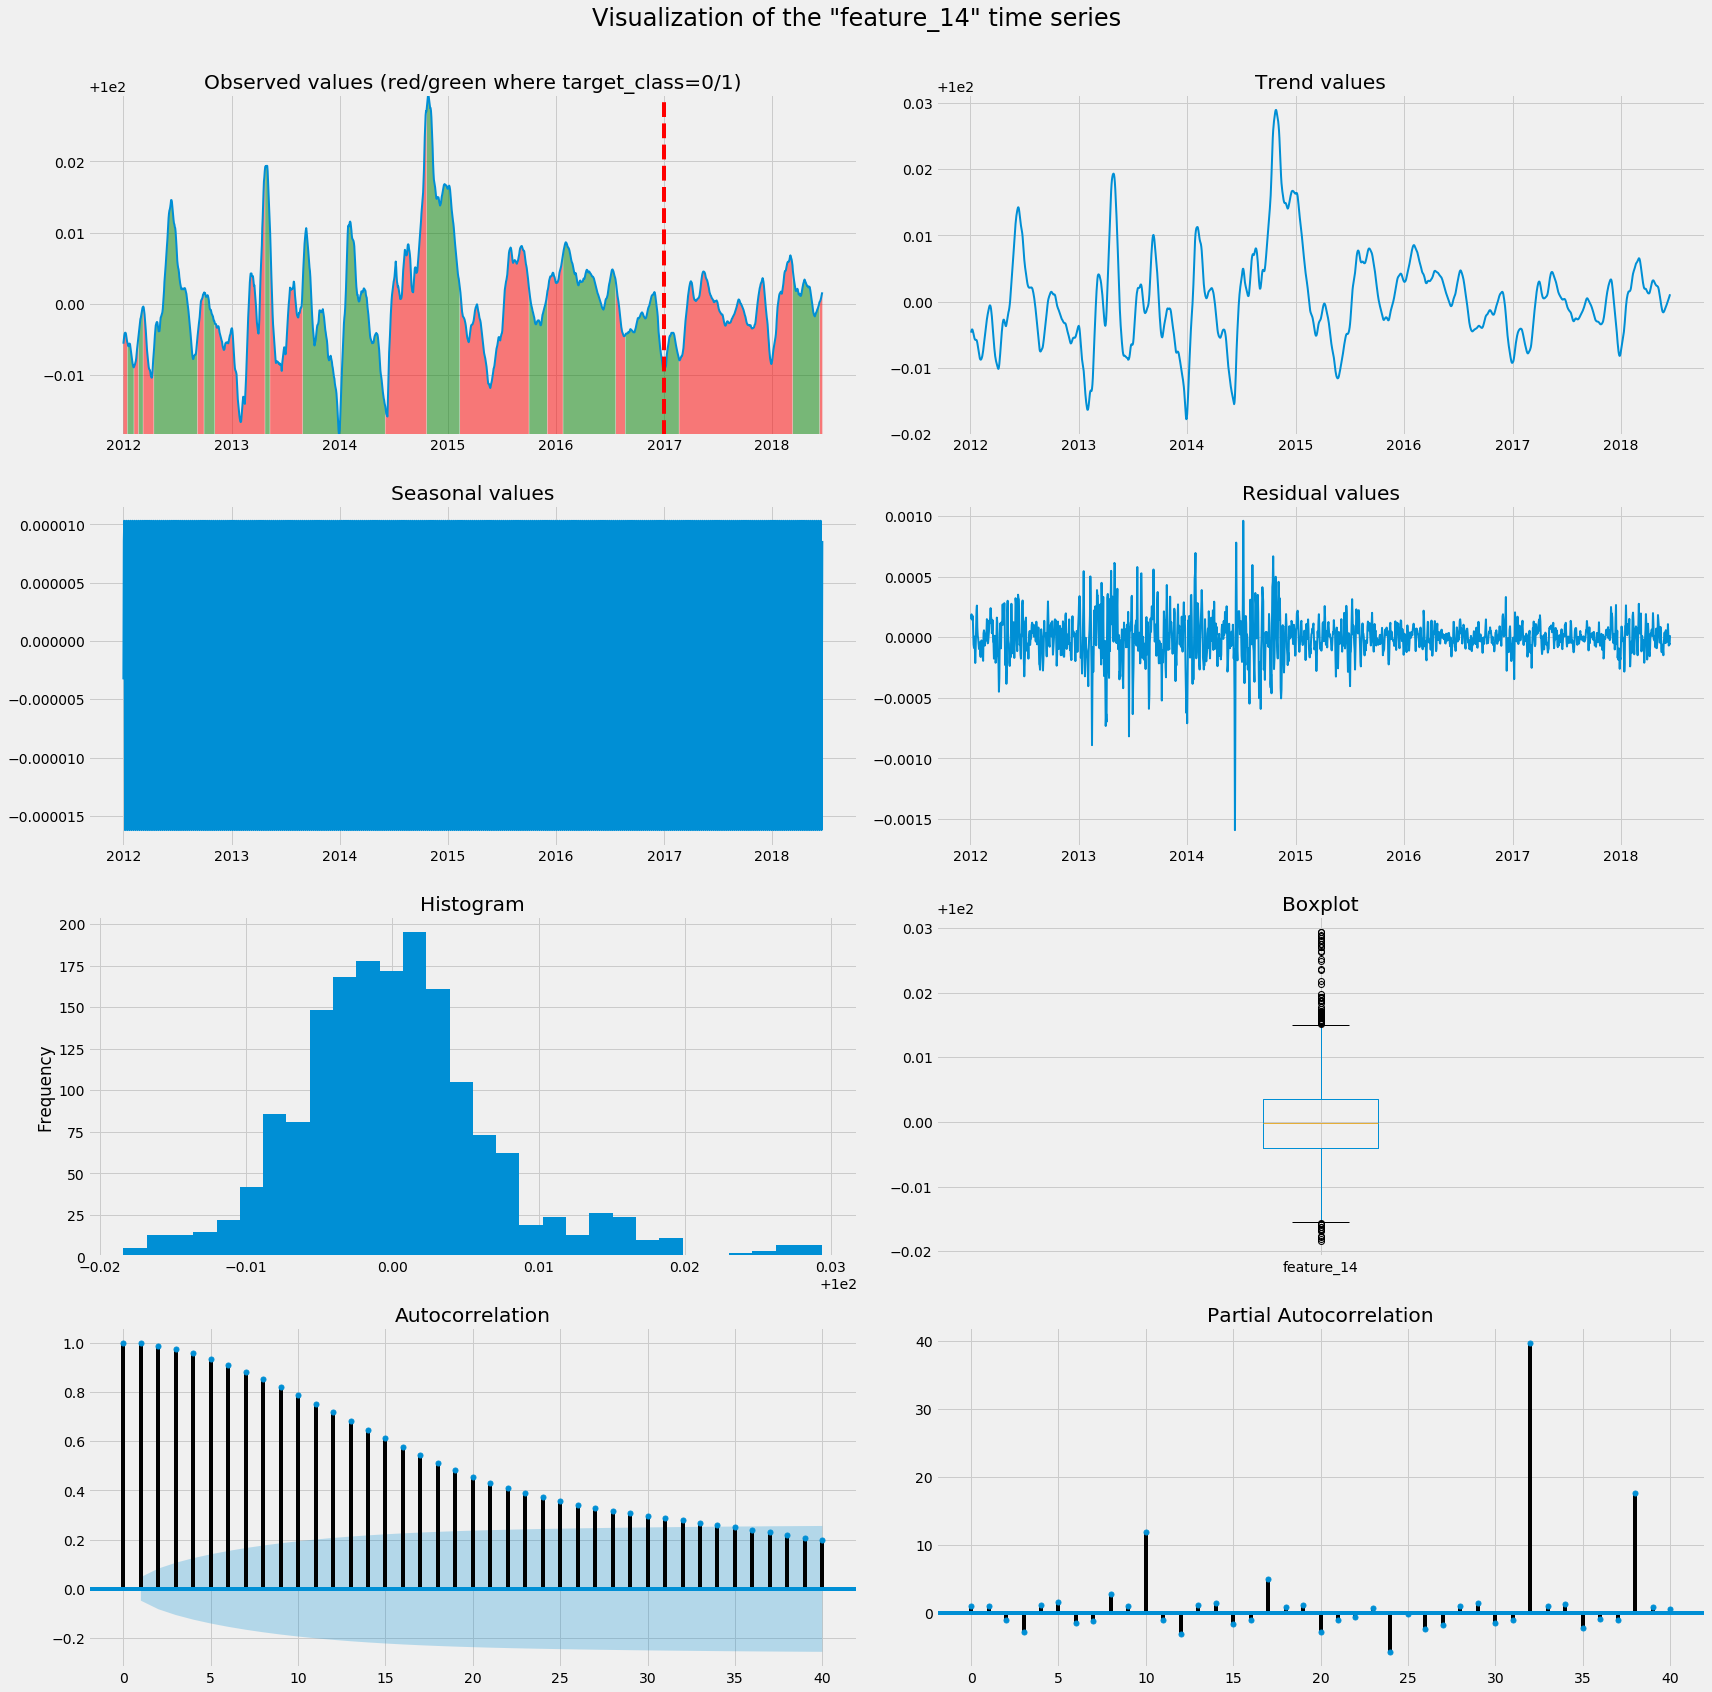

In [57]:
# Call EDA function to explore the time series
eda(df, 'feature_14')

# <a name="feature_15"></a> A-15. feature_15
[Back to INDEX](#index)

Statistic of feature_15 time series
count    1687.000000
mean      100.007692
std         0.065032
min        99.808770
25%        99.971110
50%       100.012910
75%       100.048680
max       100.225190
Name: feature_15, dtype: float64


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


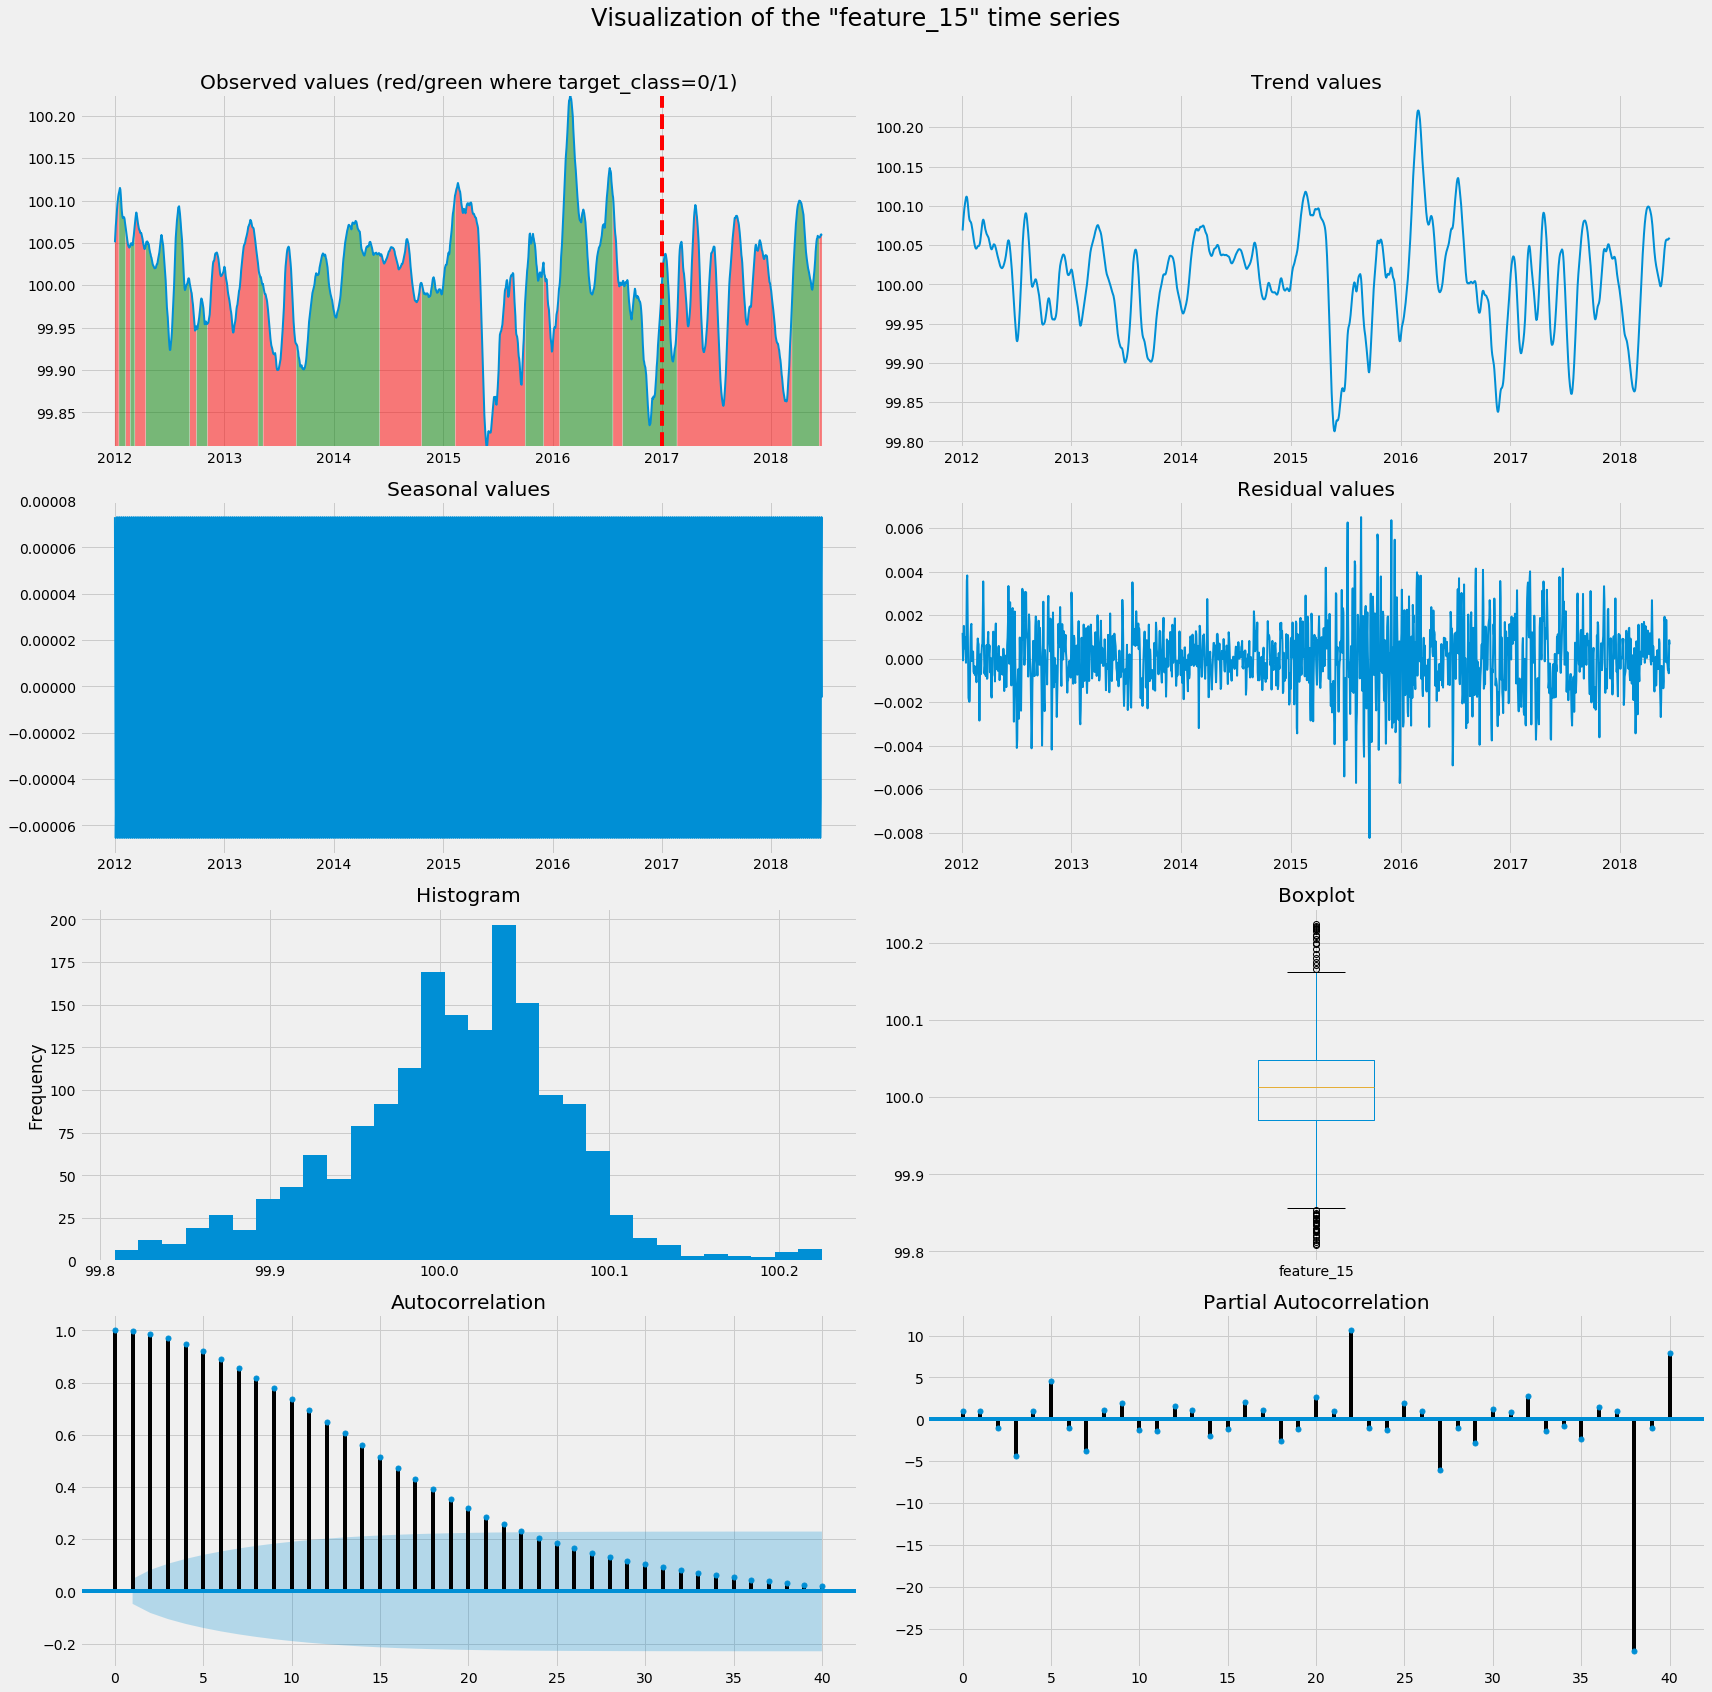

In [58]:
# Call EDA function to explore the time series
eda(df, 'feature_15')

# <a name="feature_16"></a> A-16. feature_16
[Back to INDEX](#index)

In [59]:
# Call EDA function to explore the time series
eda(df, 'feature_16')

Statistic of feature_16 time series
count    1687.000000
mean      100.000201
std         0.002521
min        99.992860
25%        99.998700
50%        99.999980
75%       100.001530
max       100.009500
Name: feature_16, dtype: float64


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
